In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import MathsUtilities as MUte
from scipy import stats
from scipy import optimize
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.dates as mdates
import CAMP as camp
import copy
import json
%matplotlib inline

In [2]:
Envs = ['WL', 'CL', 'WS', 'CS']

In [3]:
EnvNameMap = pd.Series(index=['LN','LV','SN','SV'],data=Envs)

In [4]:
EnvNameMap

LN    WL
LV    CL
SN    WS
SV    CS
dtype: object

In [5]:
SowDates = pd.Series(index = Envs,data = ['2018-11-03','2018-11-03','2018-07-06','2018-08-04'])
SowDates

WL    2018-11-03
CL    2018-11-03
WS    2018-07-06
CS    2018-08-04
dtype: object

In [6]:
TransitionDates =  pd.Series(index = Envs,data = ['2018-11-04','2019-01-04','2018-07-07','2018-09-28'])
TransitionDates

WL    2018-11-04
CL    2019-01-04
WS    2018-07-07
CS    2018-09-28
dtype: object

## Bring in trial design data frame

In [7]:
Design = pd.read_excel('./RawData/NPI_Agribio2018/expdb_AgriBio2018.xlsx',sheet_name='Design')
Design.set_index('Plot',inplace=True)

## Bring in MetData to calculate thermal time

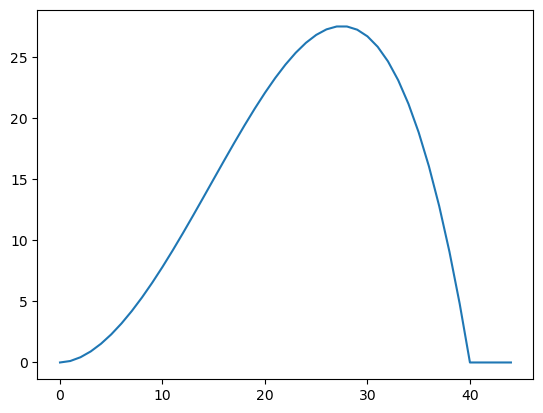

In [8]:
def WETempResponse(T,MinTemp,OptTemp,MaxTemp):
    p = np.log(2.0) / np.log((MaxTemp - MinTemp) / (OptTemp - MinTemp));
    RelEff = (2 * np.power(T - MinTemp, p) * np.power(OptTemp - MinTemp, p) - np.power(T - MinTemp, 2 * p)) / np.power(OptTemp - MinTemp, 2 * p);
    return max(0,RelEff * OptTemp)

xs = range(45)
ys = []
for x in xs:
    ys.append(WETempResponse(x,0,27.5,40))
plt.plot(xs,ys,'-')

In [9]:
#Bring in the APSIM met files
WLmet = pd.read_csv('./RawData/NPI_Agribio2018/LN.met',sep='\t',skiprows=11)
WLmet.drop(0,inplace=True)
for c in WLmet.columns:
    WLmet[c] = pd.to_numeric(WLmet.loc[:,c])
WLmet.loc[:,'date'] = [dt.datetime(WLmet.loc[x,'year'],1,1) + dt.timedelta(float(WLmet.loc[x,'day'])) for x in WLmet.index]
WLmet.set_index('date',inplace=True)
WLmet.drop(['year','day'],axis=1,inplace=True)
WLmet.loc[SowDates['WL']:,'AccumTtSow'] = WLmet.loc[SowDates['WL']:,'mint'].cumsum()
WLmet.loc[:,'WETt'] = [WETempResponse(WLmet.loc[x,'mint'],0,27.5,40) for x in WLmet.index]
WLmet.loc[SowDates['WL']:,'AccumWETtSow'] = WLmet.loc[SowDates['WL']:,'WETt'].cumsum()

WSmet = pd.read_csv('./RawData/NPI_Agribio2018/SN.met',sep='\t',skiprows=11)
WSmet.drop(0,inplace=True)
for c in WSmet.columns:
    WSmet[c] = pd.to_numeric(WSmet.loc[:,c])
WSmet.loc[:,'date'] = [dt.datetime(WSmet.loc[x,'year'],1,1) + dt.timedelta(float(WSmet.loc[x,'day'])) for x in WSmet.index]
WSmet.set_index('date',inplace=True)
WSmet.drop(['year','day'],axis=1,inplace=True)
WSmet.loc[SowDates['WS']:,'AccumTtSow'] = WSmet.loc[SowDates['WS']:,'mint'].cumsum()
WSmet.loc[:,'WETt'] = [WETempResponse(WSmet.loc[x,'mint'],0,27.5,40) for x in WSmet.index]
WSmet.loc[SowDates['WS']:,'AccumWETtSow'] = WSmet.loc[SowDates['WS']:,'WETt'].cumsum()


CLmet = pd.read_csv('./RawData/NPI_Agribio2018/LV.met',sep='\t',skiprows=11)
CLmet.drop(0,inplace=True)
for c in CLmet.columns:
    CLmet[c] = pd.to_numeric(CLmet.loc[:,c])
CLmet.loc[:,'date'] = [dt.datetime(CLmet.loc[x,'year'],1,1) + dt.timedelta(float(CLmet.loc[x,'day'])) for x in CLmet.index]
CLmet.set_index('date',inplace=True)
CLmet.drop(['year','day'],axis=1,inplace=True)
CLmet.loc[SowDates['CL']:,'AccumTtSow'] = CLmet.loc[SowDates['CL']:,'mint'].cumsum()
CLmet.loc[:,'WETt'] = [WETempResponse(CLmet.loc[x,'mint'],0,27.5,40) for x in CLmet.index]
CLmet.loc[SowDates['CL']:,'AccumWETtSow'] = CLmet.loc[SowDates['CL']:,'WETt'].cumsum()

CSmet = pd.read_csv('./RawData/NPI_Agribio2018/SV.met',sep='\t',skiprows=11)
CSmet.drop(0,inplace=True)
for c in CSmet.columns:
    CSmet[c] = pd.to_numeric(CSmet.loc[:,c])
CSmet.loc[:,'date'] = [dt.datetime(CSmet.loc[x,'year'],1,1) + dt.timedelta(float(CSmet.loc[x,'day'])) for x in CSmet.index]
CSmet.set_index('date',inplace=True)
CSmet.drop(['year','day'],axis=1,inplace=True)
CSmet.loc[SowDates['CS']:,'AccumTtSow'] = CSmet.loc[SowDates['CS']:,'mint'].cumsum()
CSmet.loc[:,'WETt'] = [WETempResponse(CSmet.loc[x,'mint'],0,27.5,40) for x in CSmet.index]
CSmet.loc[SowDates['CS']:,'AccumWETtSow'] = CSmet.loc[SowDates['CS']:,'WETt'].cumsum()

#Bring in the datalogger data from in the growth rooms
Temp = pd.read_excel('./RawData/NPI_Agribio2018/GrowthRoomTemp.xlsx')
Temp.Date = pd.to_datetime(Temp.Date)
Temp['Environment'] = [EnvNameMap[Temp.loc[x,'Environment']] for x in Temp.index]
Temp.set_index(['Environment','Date'],inplace=True)
CanopyTemp = pd.read_excel('./RawData/NPI_Agribio2018/GrowthRoomsCanopyTemp.xlsx',header=2)
CanopyTemp.Date = pd.to_datetime(CanopyTemp.Date)
CanopyTemp['Environment'] = [EnvNameMap[CanopyTemp.loc[x,'Environment']] for x in CanopyTemp.index]
CanopyTemp.set_index(['Environment','Date'],inplace=True)

WSmet.loc[:,'SoilTemp'] = Temp.loc['WS','SoilTemp'].resample('D').mean()
CSmet.loc[:,'SoilTemp'] = Temp.loc['CS','SoilTemp'].resample('D').mean()
WLmet.loc[:,'SoilTemp'] = Temp.loc['WL','SoilTemp'].resample('D').mean()
CLmet.loc[:,'SoilTemp'] = Temp.loc['CL','SoilTemp'].resample('D').mean()

WSmet.loc[:,'AccumSoilTtSow'] = WSmet.loc[SowDates['WS']:,'SoilTemp'].cumsum()
CSmet.loc[:,'AccumSoilTtSow'] = CSmet.loc[SowDates['CS']:,'SoilTemp'].cumsum()
WLmet.loc[:,'AccumSoilTtSow'] = WLmet.loc[SowDates['WL']:,'SoilTemp'].cumsum()
CLmet.loc[:,'AccumSoilTtSow'] = CLmet.loc[SowDates['CL']:,'SoilTemp'].cumsum()

Met = pd.concat([WSmet,WLmet,CSmet,CLmet],keys=['WS','WL','CS','CL'])

## Graph up met data to check it looks right

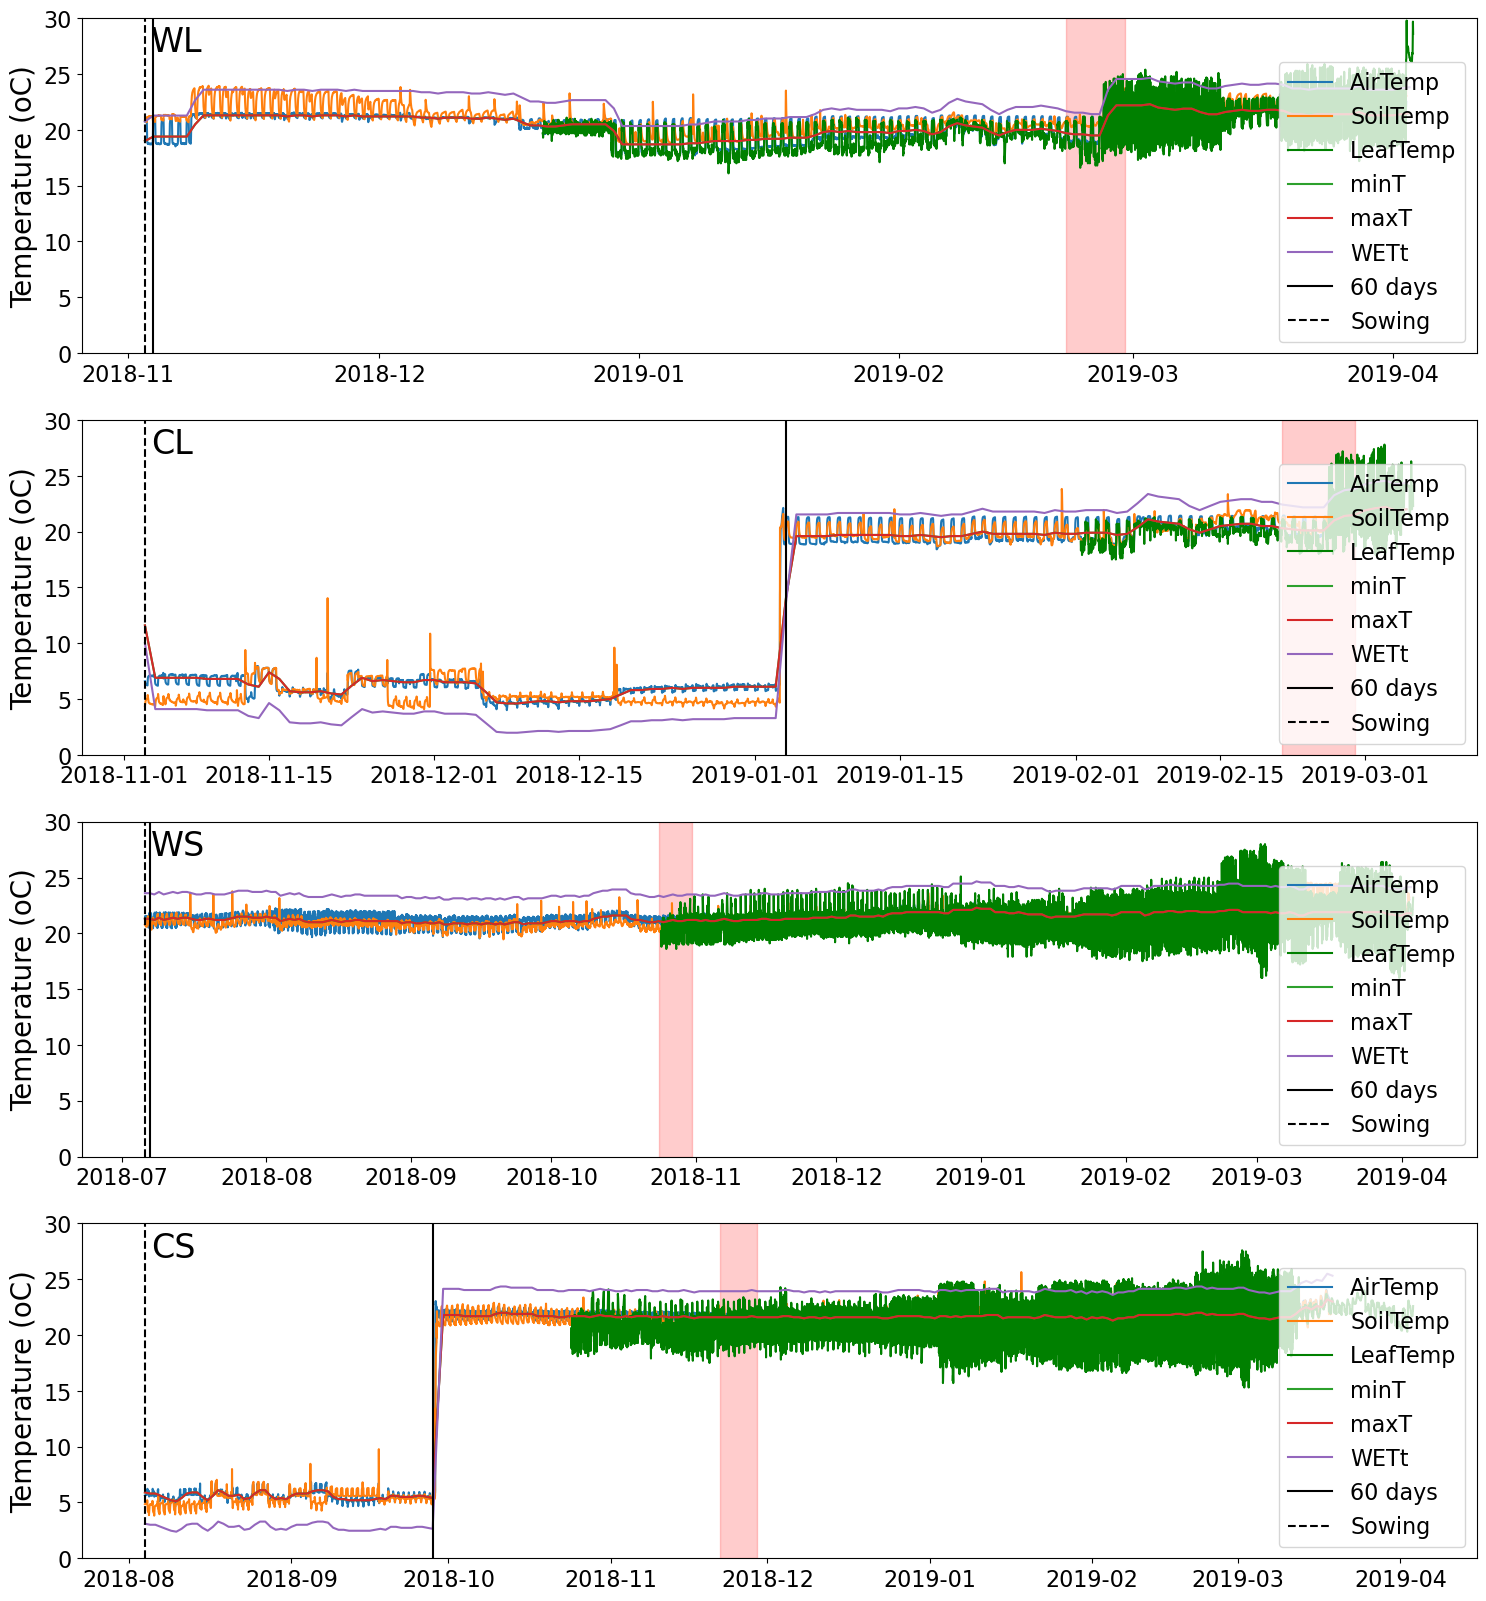

In [10]:
Graph = plt.figure(figsize=(18,20))
pos=1
for e in Envs:
    ax = Graph.add_subplot(4,1,pos)
    SowDate = pd.to_datetime(SowDates[e])
    ChangeDate = pd.to_datetime(TransitionDates[e])
    StartSlice = SowDate + dt.timedelta(110)
    EndSlice = StartSlice + dt.timedelta(7)
    plt.plot(Temp.loc[e,'AirTemp'].loc[SowDate:],label='AirTemp')
    plt.plot(Temp.loc[e,'SoilTemp'].loc[SowDate:],label='SoilTemp')
    plt.plot(CanopyTemp.loc[e,'LeafTemp'].loc[SowDate:],color='g',label='LeafTemp')
    plt.plot(Met.loc[e,'mint'].loc[SowDate:],label='minT')
    plt.plot(Met.loc[e,'maxt'].loc[SowDate:],label='maxT')
    plt.plot(Met.loc[e,'WETt'].loc[SowDate:],label='WETt')
    plt.plot([ChangeDate]*2,[0,30],color='k',label='60 days')
    plt.plot([SowDate]*2,[0,30],'--',color='k',label='Sowing')
    ax.axvspan(StartSlice,EndSlice,alpha=0.2,color='r')
    plt.text(0.05,0.9,e,transform = ax.transAxes,fontsize=24)
    plt.ylim(0,30)
    plt.legend(loc=4,fontsize=16)
    plt.ylabel('Temperature (oC)',fontsize=20)
    plt.tick_params(labelsize=16)
    pos+=1
Graph.patch.set_facecolor('white')

### The pink shaded period is expanded in the plot below

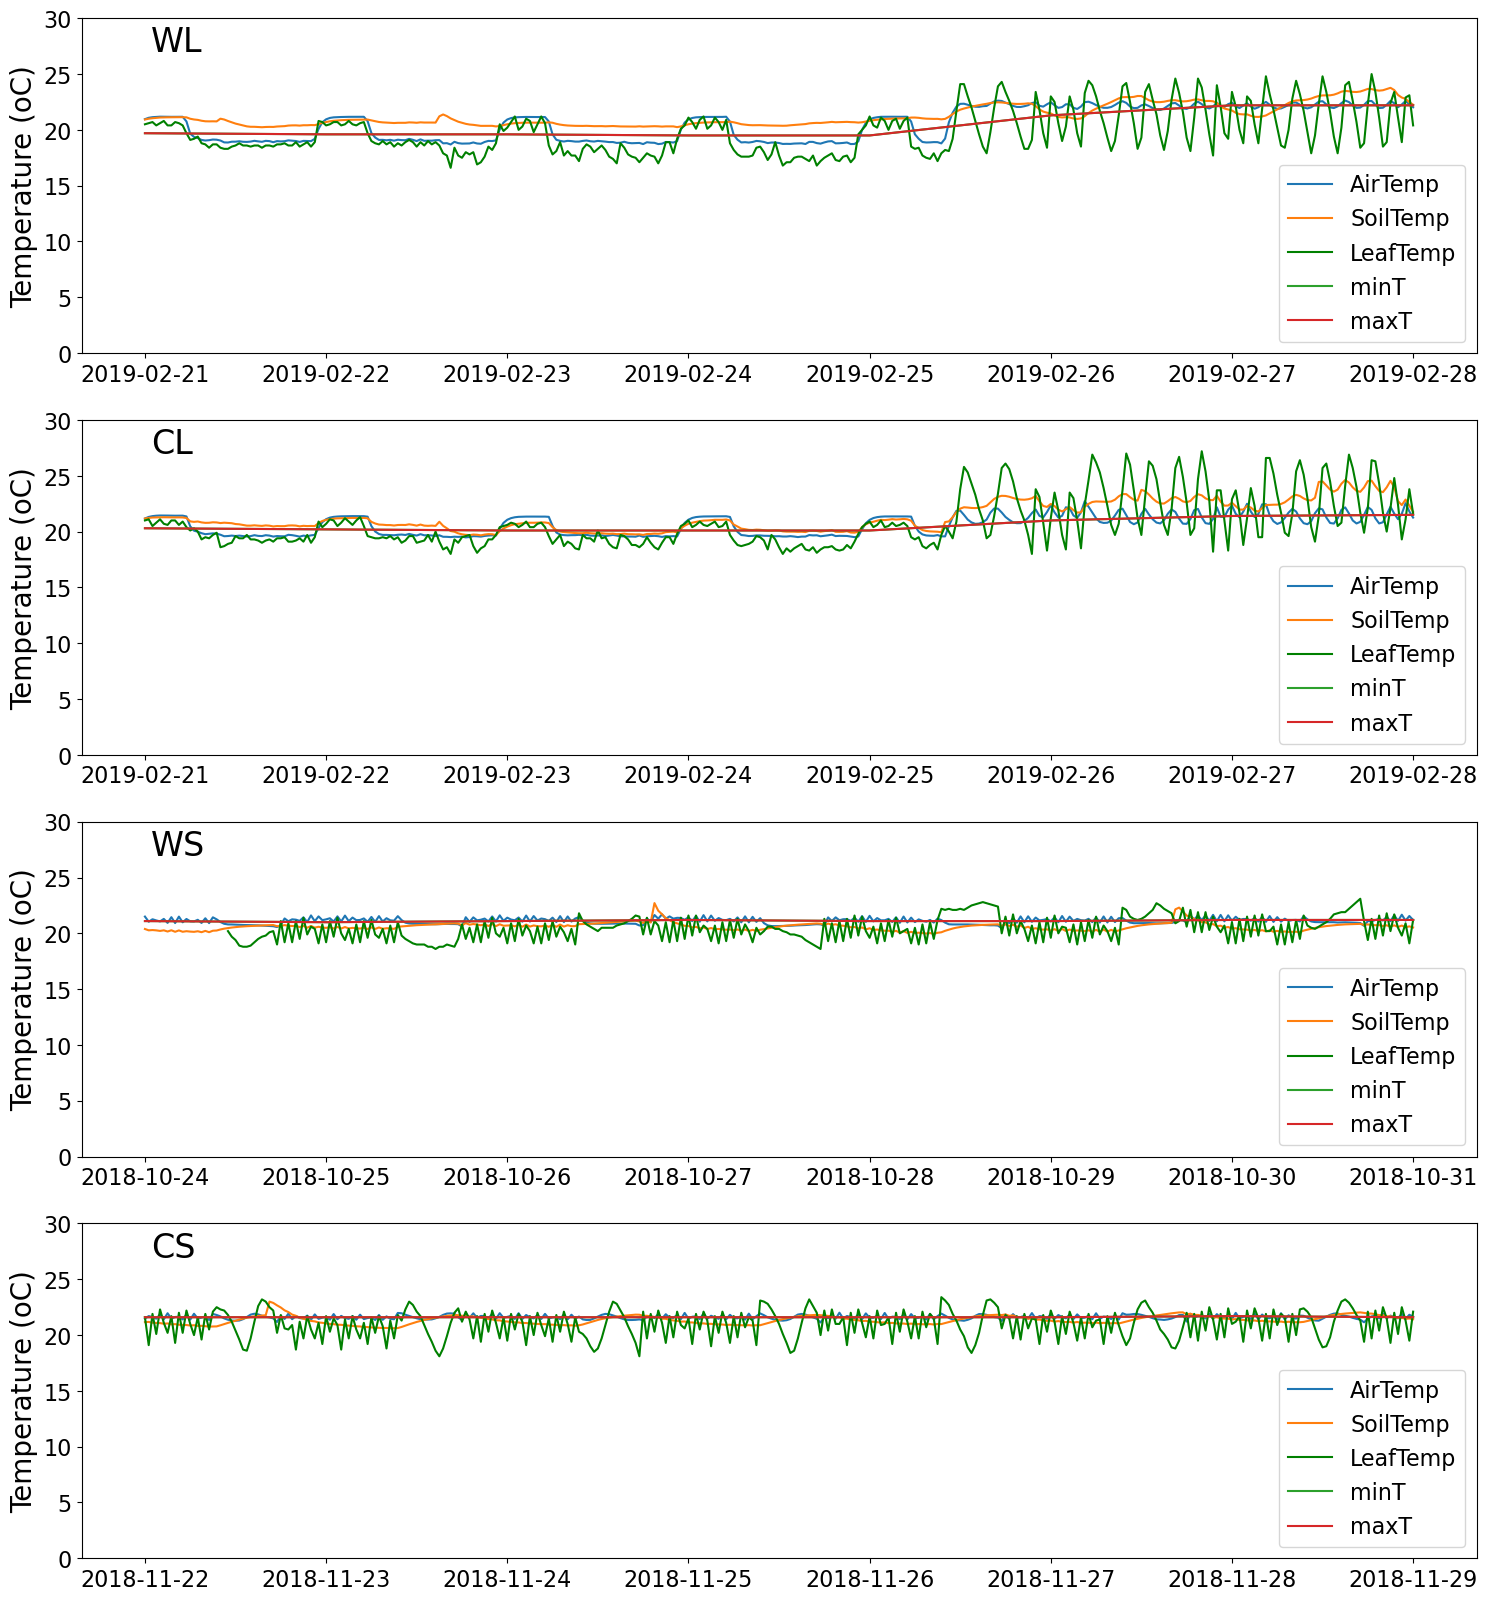

In [11]:
Graph = plt.figure(figsize=(18,20))
pos=1
for e in Envs:
    ax = Graph.add_subplot(4,1,pos)
    SowDate = pd.to_datetime(SowDates[e])
    ChangeDate = SowDate + dt.timedelta(60)
    StartSlice = SowDate + dt.timedelta(110)
    EndSlice = StartSlice + dt.timedelta(7)
    plt.plot(Temp.loc[e,'AirTemp'].loc[StartSlice:EndSlice],label='AirTemp')
    plt.plot(Temp.loc[e,'SoilTemp'].loc[StartSlice:EndSlice],label='SoilTemp')
    plt.plot(CanopyTemp.loc[e,'LeafTemp'].loc[StartSlice:EndSlice],color='g',label='LeafTemp')
    plt.plot(Met.loc[e,'mint'].loc[StartSlice:EndSlice],label='minT')
    plt.plot(Met.loc[e,'mint'].loc[StartSlice:EndSlice],label='maxT')
    plt.text(0.05,0.9,e,transform = ax.transAxes,fontsize=24)
    plt.ylim(0,30)
    plt.legend(loc=4,fontsize=16)
    plt.ylabel('Temperature (oC)',fontsize=20)
    plt.tick_params(labelsize=16)
    pos+=1
Graph.patch.set_facecolor('white')

## Points to note
- Duration of vernalisation treatment was less for the CS treatment
- Air, soil and leaf tempertures appear close together and the temperaures we have in the APSIM file do a reasonable job of approximating this.

## Bring in the emergence date data

In [12]:
EmergenceDate = pd.read_excel('./RawData/NPI_Agribio2018/expdb_AgriBio2018.xlsx',sheet_name='Phenotype_EmergenceDate')
EmergenceDate.set_index('Plot',inplace=True)

## Bring in the leaf appearance data and set indices

In [13]:
def find_date(A, target):
    #A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return A.index[idx]

In [14]:
HSData = pd.read_excel('./RawData/NPI_Agribio2018/expdb_AgriBio2018.xlsx',sheet_name='Phenotype_HI')
HSData.loc[:,'Genotype'] = [Design.loc[x,'Genotype'] for x in HSData.loc[:,'Plot']]
HSData.loc[:,'Environment'] = [Design.loc[x,'TrialCode'].split('-')[1] for x in HSData.loc[:,'Plot']]
HSData.loc[:,'Environment'] = [EnvNameMap[HSData.loc[x,'Environment']] for x in HSData.index]
HSData.loc[:,'AirTemp'] =[Met.loc[(HSData.loc[x,'Environment'],HSData.loc[x,'Date']),'maxt'] for x in HSData.index]
HSData.loc[:,'TT'] = [Met.loc[(HSData.loc[x,'Environment'],HSData.loc[x,'Date']),'AccumTtSow'] for x in HSData.index]
HSData.loc[:,'SoilT'] = [Met.loc[(HSData.loc[x,'Environment'],HSData.loc[x,'Date']),'SoilTemp'] for x in HSData.index]
HSData.loc[:,'SoilTt'] = [Met.loc[(HSData.loc[x,'Environment'],HSData.loc[x,'Date']),'AccumSoilTtSow'] for x in HSData.index]
HSData.loc[:,'EmergenceDate'] = [EmergenceDate.loc[x,'Date'] for x in HSData.loc[:,'Plot']]
HSData.loc[:,'EmergTt'] = [Met.loc[(HSData.loc[x,'Environment'],HSData.loc[x,'EmergenceDate']),'AccumTtSow'] for x in HSData.index]
HSData.loc[:,'EmergSoilTt'] = [Met.loc[(HSData.loc[x,'Environment'],HSData.loc[x,'EmergenceDate']),'AccumSoilTtSow'] for x in HSData.index]
HSData.set_index(['Environment','Genotype','Range','Date'],inplace=True)
HSData.dropna(how='all',inplace=True)
HSData.sort_index(inplace=True)

In [15]:
def apexTemp(ind):
    if HSData.loc[ind,'Value'] < 3:
        return HSData.loc[ind,'SoilTt']
    else:
        return HSData.loc[ind,'ApexEmergAccumtSoilT'] + (HSData.loc[ind,'TT'] - HSData.loc[ind,'ApexEmergAccumtAirT'])

In [16]:
plotindex = HSData.index.droplevel(['Date']).drop_duplicates()
for p in plotindex:
    HSData.loc[p,'ApexEmergDate'] = find_date(HSData.loc[p,'Value'],3)
    HSData.loc[p,'ApexEmergAccumtSoilT'] = Met.loc[(p[0],HSData.loc[p,'ApexEmergDate'].drop_duplicates().values[0]),'AccumSoilTtSow']
    HSData.loc[p,'ApexEmergAccumtAirT'] = Met.loc[(p[0],HSData.loc[p,'ApexEmergDate'].drop_duplicates().values[0]),'AccumTtSow']
    HSData.loc[p,'ApexAccumTt'] = [apexTemp(p+(x,)) for x in HSData.loc[p,:].index]

## Add in zero HS value on day of emergence

In [17]:
for pot in HSData.index.droplevel(3).drop_duplicates():
    EmergeDate = EmergenceDate.loc[HSData.loc[pot,'Plot'].drop_duplicates().values[0],'Date']
    EmergenceDateIndexed = pot + (EmergeDate,)
    FirstRow = HSData.loc[pot,:].iloc[0,:]
    HSData.loc[EmergenceDateIndexed,:] = FirstRow
    HSData.loc[EmergenceDateIndexed,'Value'] = 0
    HSData.loc[EmergenceDateIndexed,'TT'] = FirstRow['EmergTt']
    HSData.loc[EmergenceDateIndexed,'SoilTt'] = FirstRow['EmergSoilTt']
    HSData.loc[EmergenceDateIndexed,'ApexAccumTt'] = FirstRow['EmergSoilTt']
HSData.sort_index(inplace=True)

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_17344\2210686657.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  HSData.loc[EmergenceDateIndexed,'Value'] = 0
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_17344\2210686657.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  HSData.loc[EmergenceDateIndexed,'TT'] = FirstRow['EmergTt']
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_17344\2210686657.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  HSData.loc[EmergenceDateIndexed,'SoilTt'] = FirstRow['EmergSoilTt']
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_17344\2210686657.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  HSData.loc[EmergenceDateIndexed,'ApexAccumTt'] = FirstRow['EmergSoilTt']
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_17344\2210686657.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  EmergeDate = EmergenceDate.loc[HSData.loc[po

## Make some useful lists

In [18]:
Cults = HSData.index.get_level_values(1).drop_duplicates().values
Cults.sort()
colors = ['r','b','r','b']
fills = ['r','b','w','w']
lines = ['-','-','--','--']

In [19]:
styles = pd.DataFrame(index = Envs, columns = ['Edge','Fill','Lines'],data = [['r','r','-'],['b','b','-'],['r','w','--'],['b','w','--']])
styles.loc['L',:] = ['gold','gold','-']
styles.loc['S',:] = ['gold','w','--']
styles

Edge  Fill Lines
WL     r     r     -
CL     b     b     -
WS     r     w    --
CS     b     w    --
L   gold  gold     -
S   gold     w    --

## Graph Haun stage data to check 

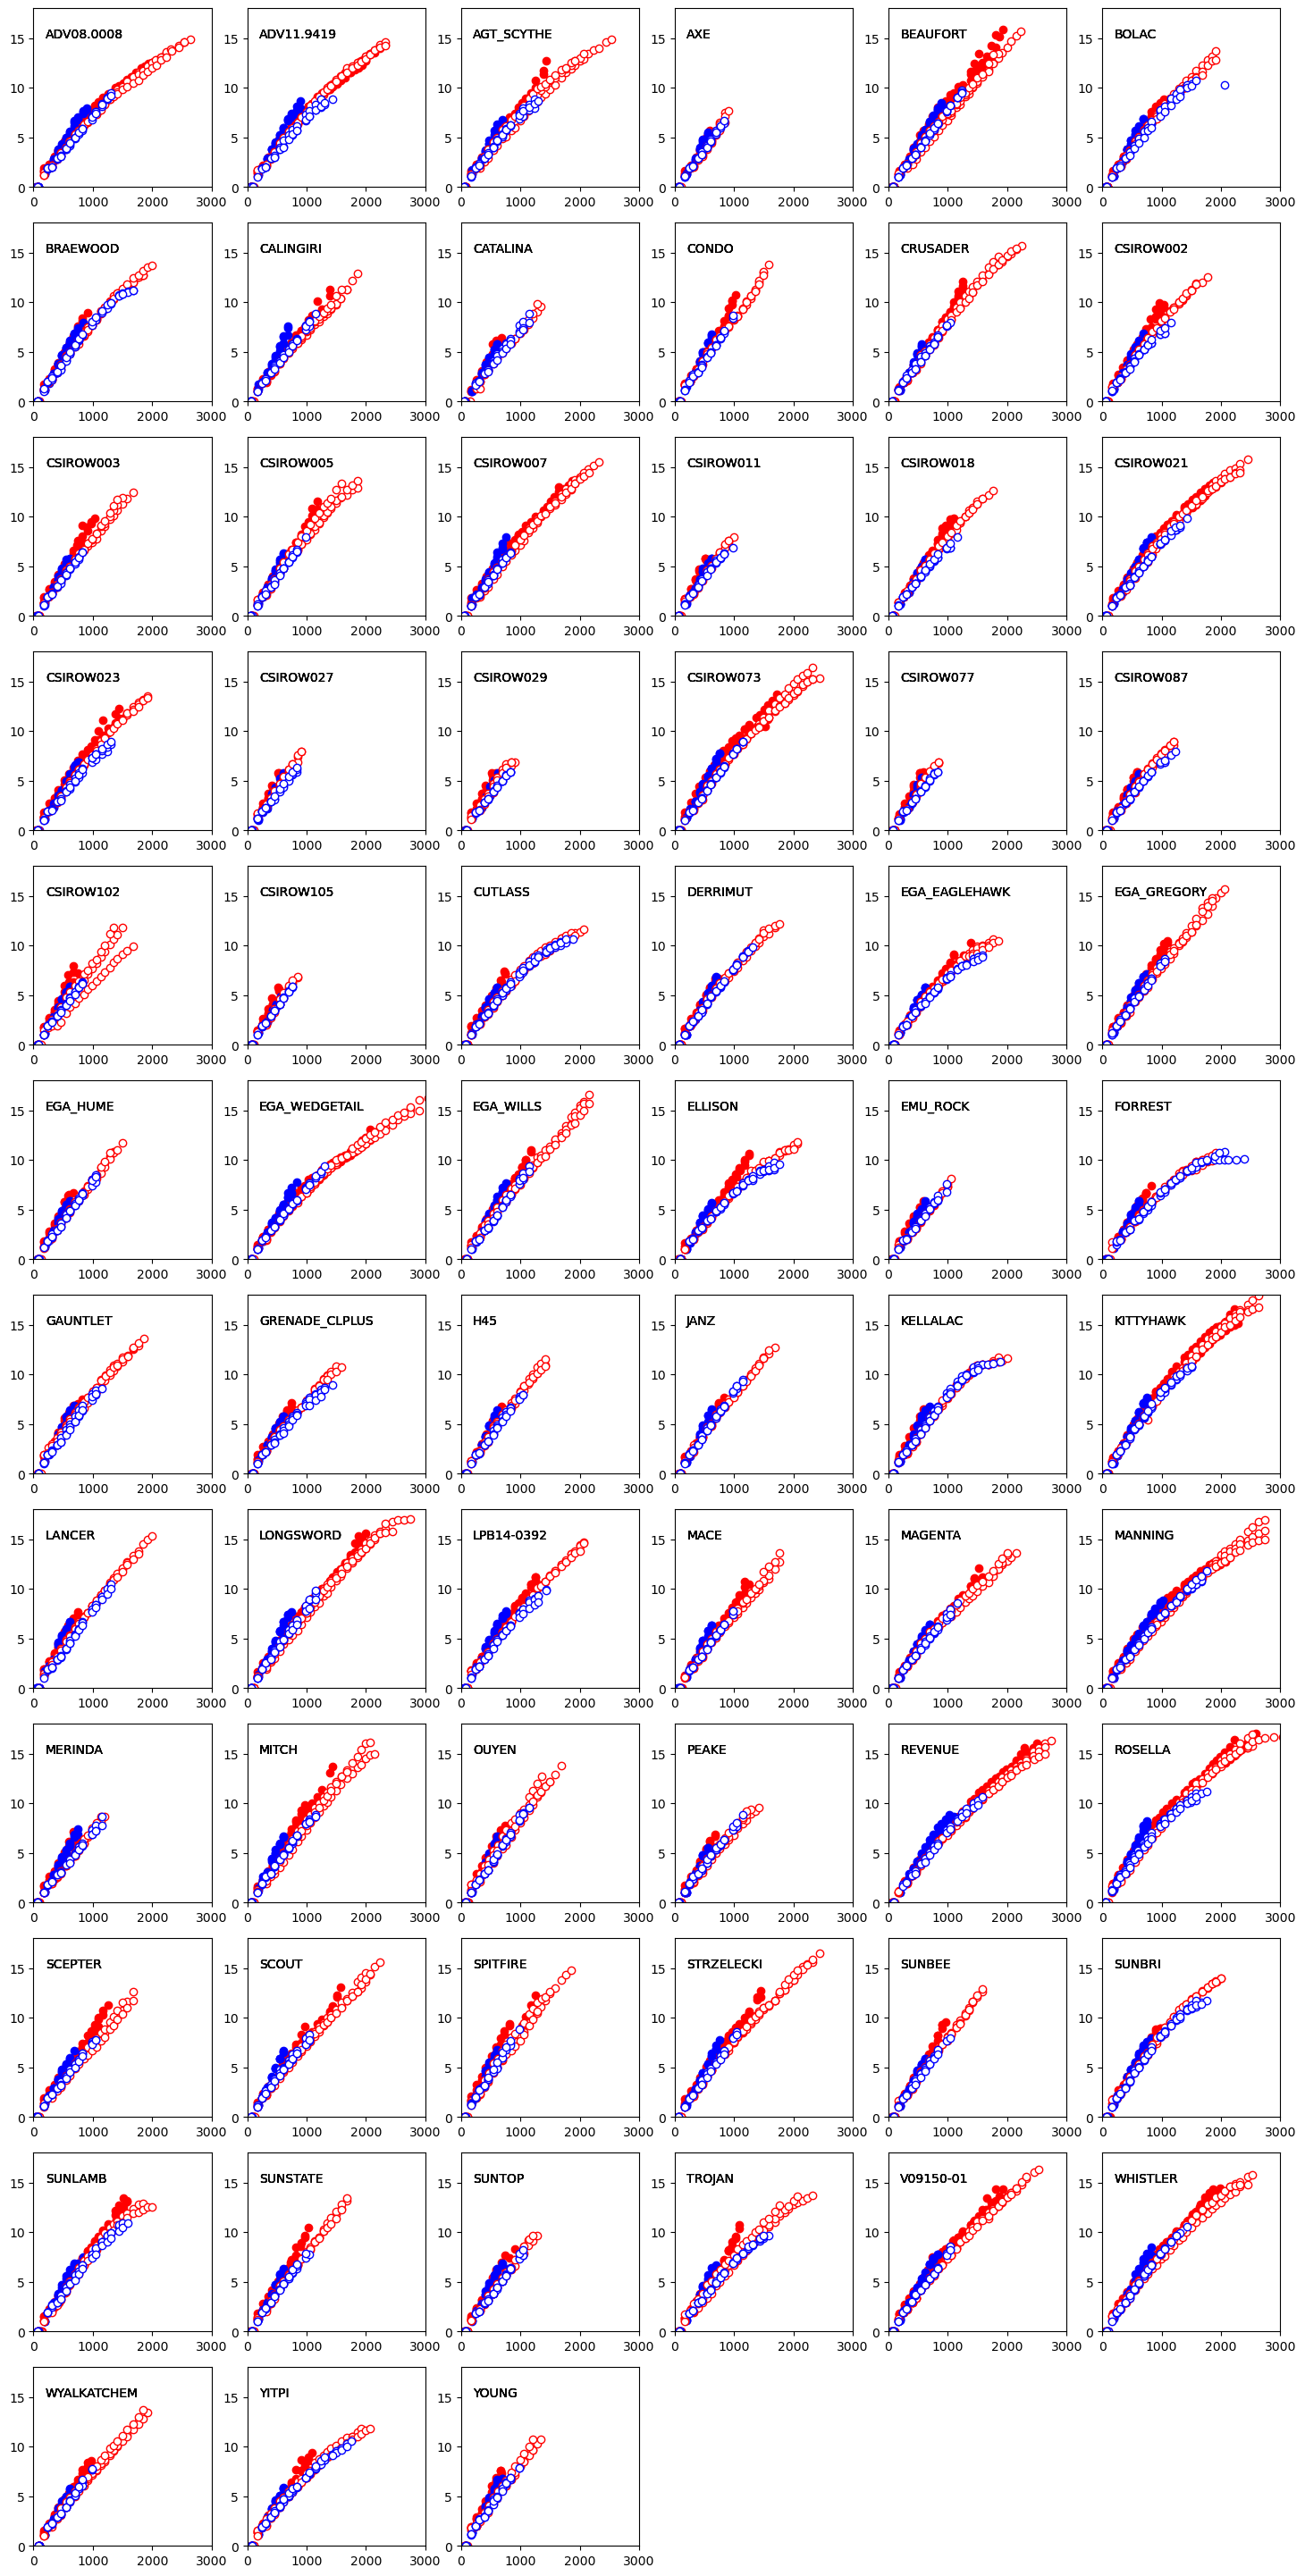

In [20]:
TreatIndex = pd.MultiIndex.from_product([Envs,Cults],names=['Environment','Cultivar'])
Graph = plt.figure(figsize=(18,40))
pos=1
for cul in Cults:
    ax = Graph.add_subplot(13,6,pos)
    pos+=1
    for env in Envs:
        y = HSData.loc[(env,cul),'Value'].dropna()
        x = HSData.loc[(env,cul),'ApexAccumTt'].reindex(y.index)
        plt.plot(x,y,'o',mec=styles.loc[env,'Edge'],mfc=styles.loc[env,'Fill'])
        plt.text(200,15,cul)
    plt.ylim(0,18)
    plt.xlim(0,3000)
Graph.patch.set_facecolor('white')

### Most data looks good but there seem to be issues with one of the reps for CSIROW102 in the WS treatment

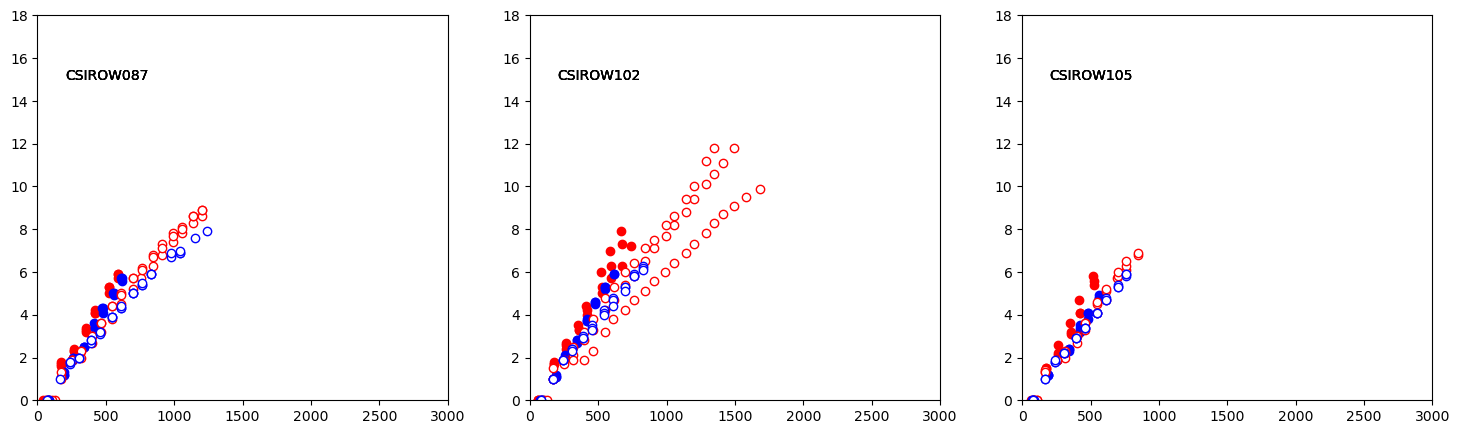

In [21]:
TreatIndex = pd.MultiIndex.from_product([Envs,Cults],names=['Environment','Cultivar'])
Graph = plt.figure(figsize=(18,5))
pos=1
for cul in Cults[23:26]:
    ax = Graph.add_subplot(1,3,pos)
    pos+=1
    for env in Envs:
        y = HSData.loc[(env,cul),'Value'].dropna()
        x = HSData.loc[(env,cul),'ApexAccumTt'].reindex(y.index)
        plt.plot(x,y,'o',mec=styles.loc[env,'Edge'],mfc=styles.loc[env,'Fill'])
        plt.text(200,15,cul)
    plt.ylim(0,18)
    plt.xlim(0,3000)
Graph.patch.set_facecolor('white')

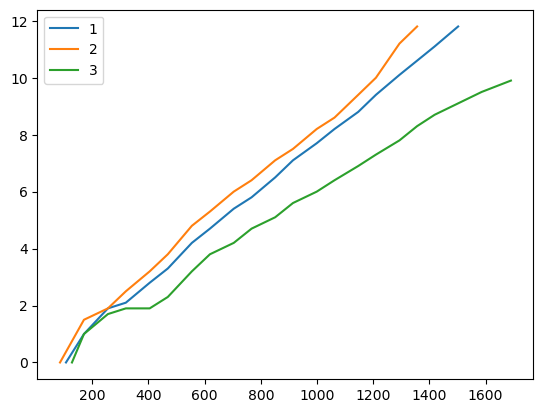

In [22]:
for b in [1,2,3]:
    plt.plot(HSData.loc[('WS','CSIROW102',b),'TT'],HSData.loc[('WS','CSIROW102',b),'Value'],label=b)
plt.legend()

## one rep was funny for CSIRO WS treatment so remove.  

In [23]:
#Remove problematic rep
HSData.loc[('WS','CSIROW102',3),'Value'] = np.nan

## Make dataframe to store fitted phyllochron values

In [24]:
TreatIndex = pd.MultiIndex.from_product([Envs,Cults],names=['Environment','Cultivar'])
FittedPhyllochron = pd.DataFrame(index = TreatIndex,columns=['FittedPhyllochron'])

def EmergenceDateDF(env,cul):
    List = HSData.loc[(env,cul),'EmergenceDate'].drop_duplicates().values
    if len(List) == 1:
        return pd.to_datetime(List[0])
    else :
        dates = pd.DataFrame(index = List,columns = ['count','date'])
        dates['count'] = [0] * len(List)
        #dates.isetitem('count', [0] * len(List))
        dates['date'] = List
        for x in List:
            dates.loc[x,'count'] = dates.loc[x,'count']+ 1
        maximum = dates.loc[:,'count'].max()
        return pd.to_datetime(dates.loc[dates.loc[:,'count']==maximum,'date'].values[0])

for cul in Cults:
    for env in Envs:
        FittedPhyllochron.loc[(env,cul),'EmergenceDate'] = EmergenceDateDF(env,cul)
        FittedPhyllochron.loc[(env,cul),'EmergSoilTt'] = HSData.loc[(env,cul),'EmergSoilTt'].mean()

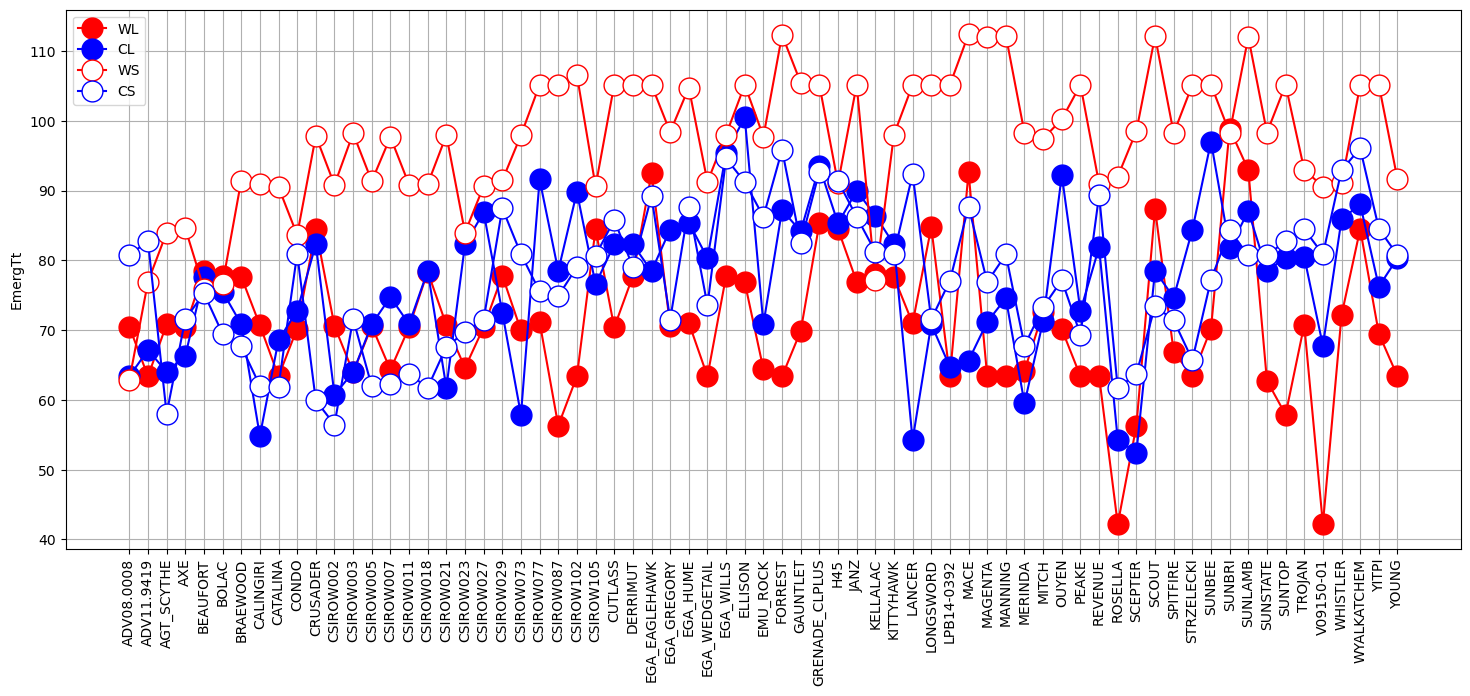

In [25]:
Graph = plt.figure(figsize=(18,7))
ax = Graph.add_subplot(1,1,1)
colpos = 0
for env in Envs:
    plt.plot(FittedPhyllochron.loc[env,'EmergSoilTt'],'-o',
             color = styles.loc[env,'Edge'],mec=styles.loc[env,'Edge'],mfc=styles.loc[env,'Fill'],label=env,ms=15)
    colpos +=1
plt.ylabel('EmergTt')
plt.grid()
for tick in ax.get_xticklabels():
            tick.set_rotation(90)
plt.legend(loc=2)
Graph.patch.set_facecolor('white')

In [26]:
def FitNPlotPhyllochron(ax,base,sufix,lineStyle):
        y = HSData.loc[base,'Value'].loc[(env,cul)].dropna()
        x = HSData.loc[(env,cul),'ApexAccumTt'].reindex(y.index)
        plt.plot(x,y,'o',mec=styles.loc[env,'Edge'],mfc=styles.loc[env,'Fill'])
        
        #Fit linear regression to current series and store slope and intercept in dataframe
        ModFit = sm.regression.linear_model.OLS(y,  # Y variable
                                            sm.add_constant(x), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
        RegFit = ModFit.fit();  # fit models parameters
        Slope = RegFit.params[1]
        FittedPhyllochron.loc[(env,cul),'LAR'+"-"+sufix] = Slope
        FittedPhyllochron.loc[(env,cul),'Phyllochron'+"-"+sufix] = 1/Slope
        FittedPhyllochron.loc[(env,cul),'r2'+"-"+sufix] = RegFit.rsquared
        FittedPhyllochron.loc[(env,cul),'SE'+"-"+sufix] = RegFit.bse[1]
        FittedPhyllochron.loc[(env,cul),'n'+"-"+sufix] = y.index.size
        Intercept = RegFit.params[0]
        fitYs = [Intercept,Intercept+Slope*3000]
        plt.plot([0,3000],fitYs,lineStyle,color = styles.loc[env,'Edge'])
        plt.text(0.03,0.9,cul, transform=ax.transAxes)

## Next we fit regressions to the data between leaves 1 and 3 to quantify early phyllochron (Phyllochron 1)

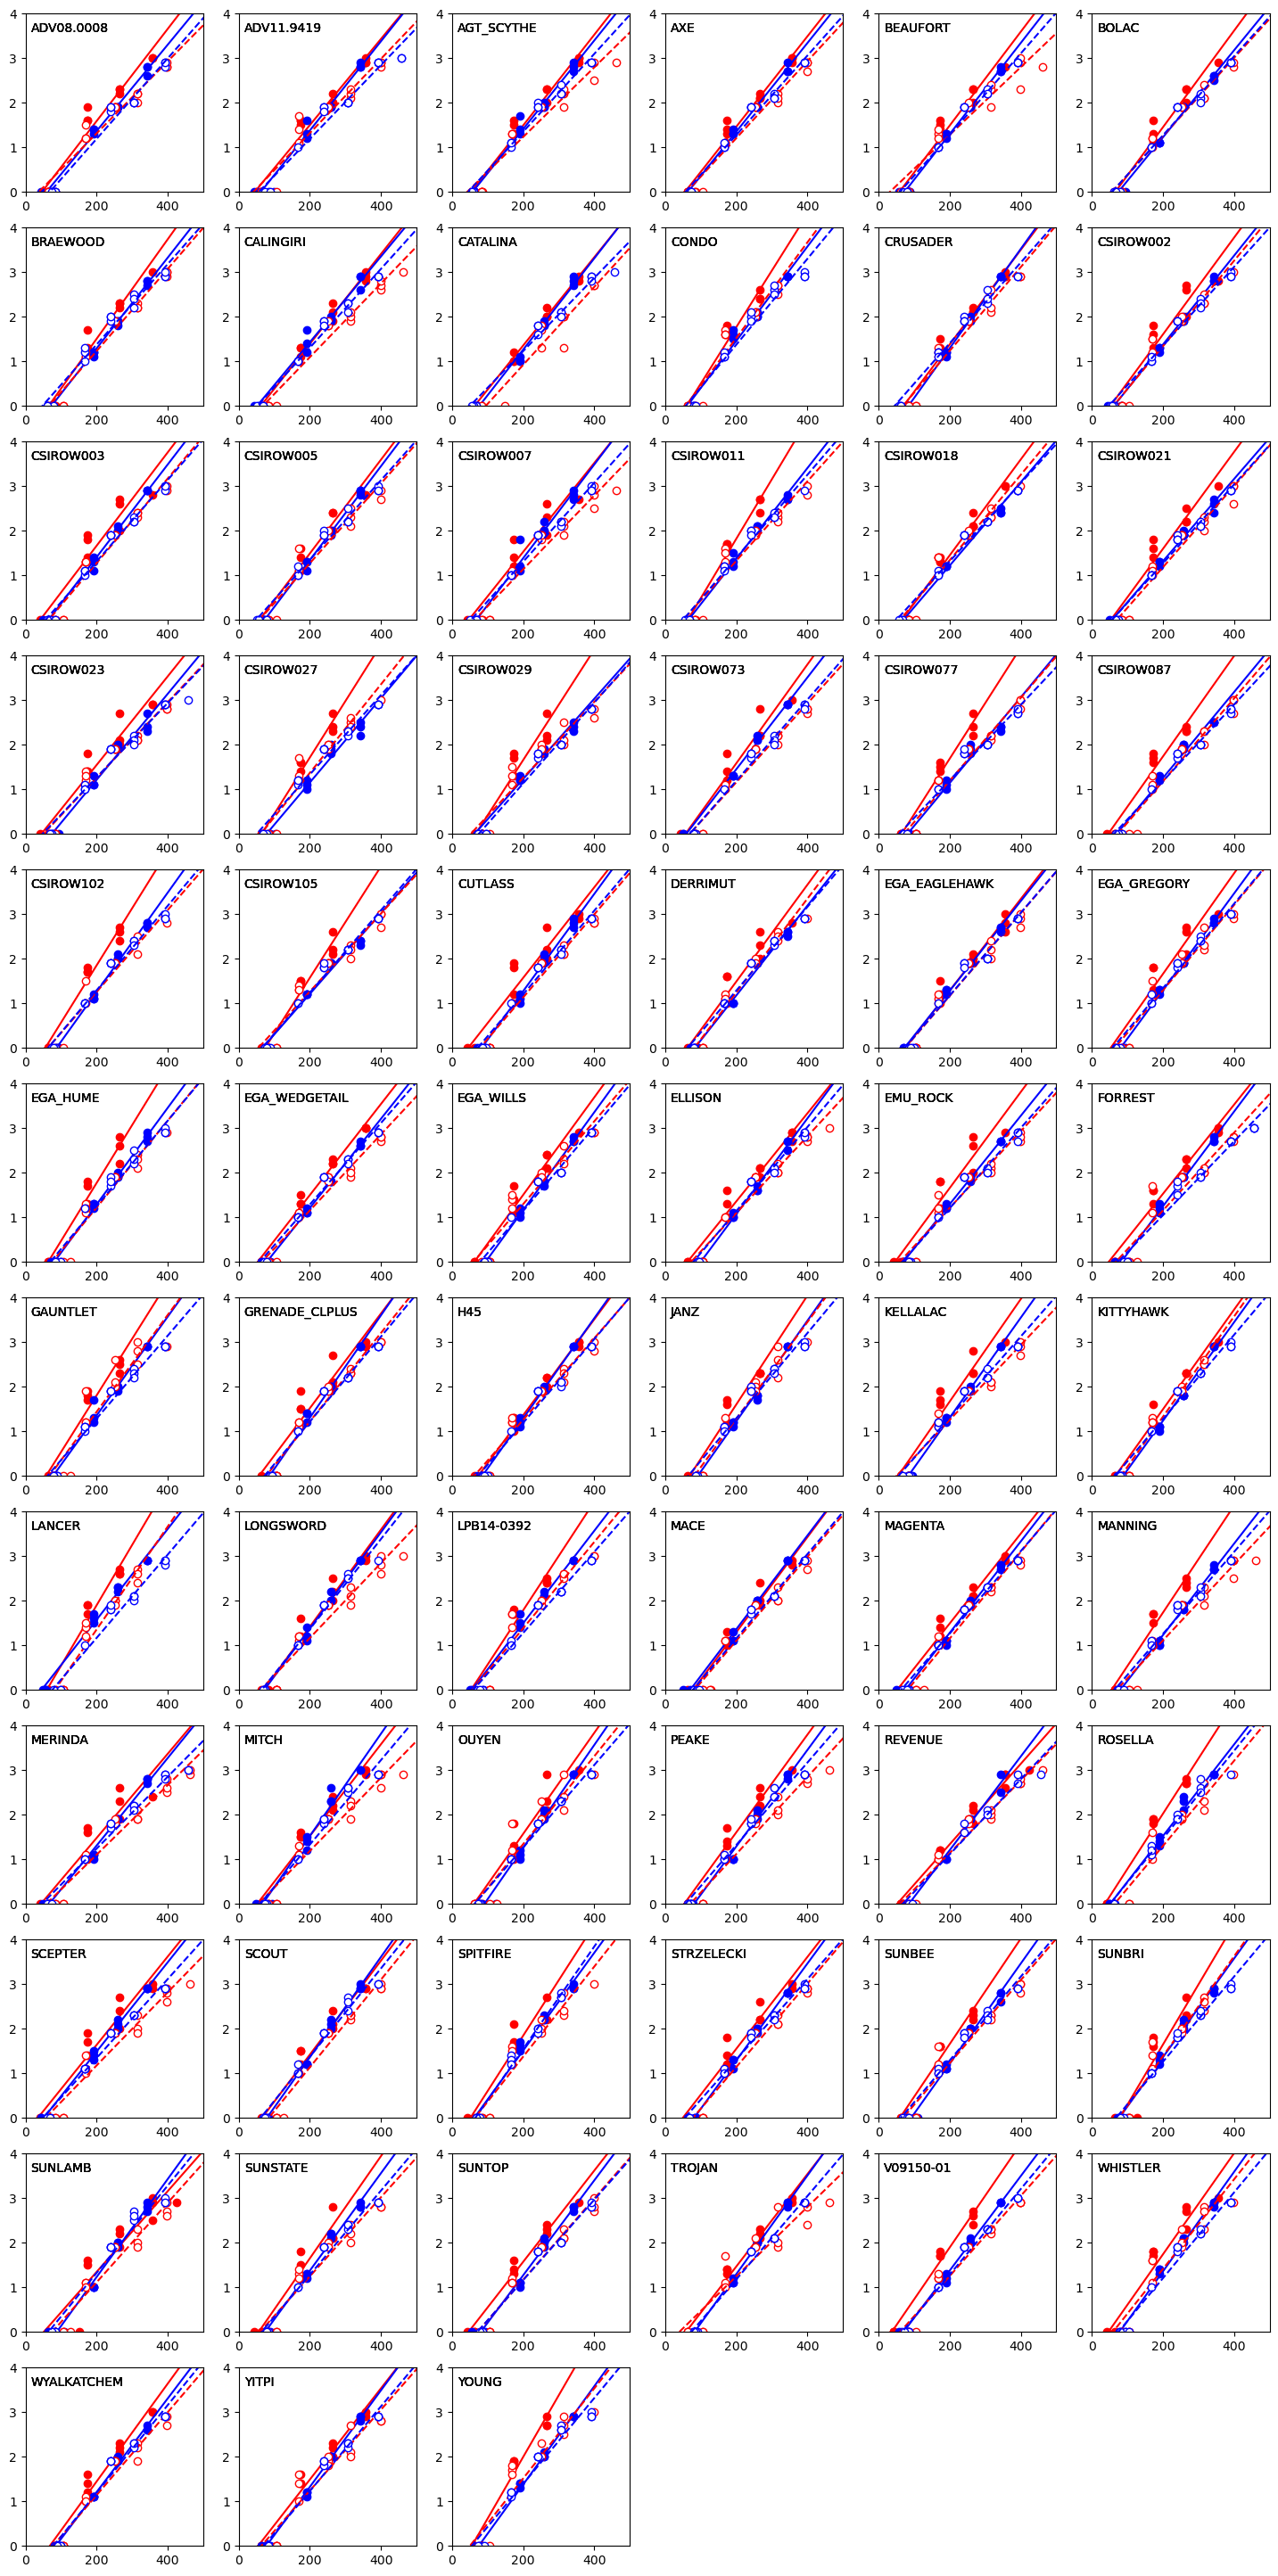

In [27]:
Graph = plt.figure(figsize=(18,40))
pos=1
for cul in Cults:
    ax = Graph.add_subplot(13,6,pos)
    pos+=1
    for env in Envs:
        base = (HSData.Value <= 3) 
        FitNPlotPhyllochron(ax, base,'1',styles.loc[env,'Lines'])
    plt.ylim(0,4)
    plt.xlim(0,500)
Graph.patch.set_facecolor('white')

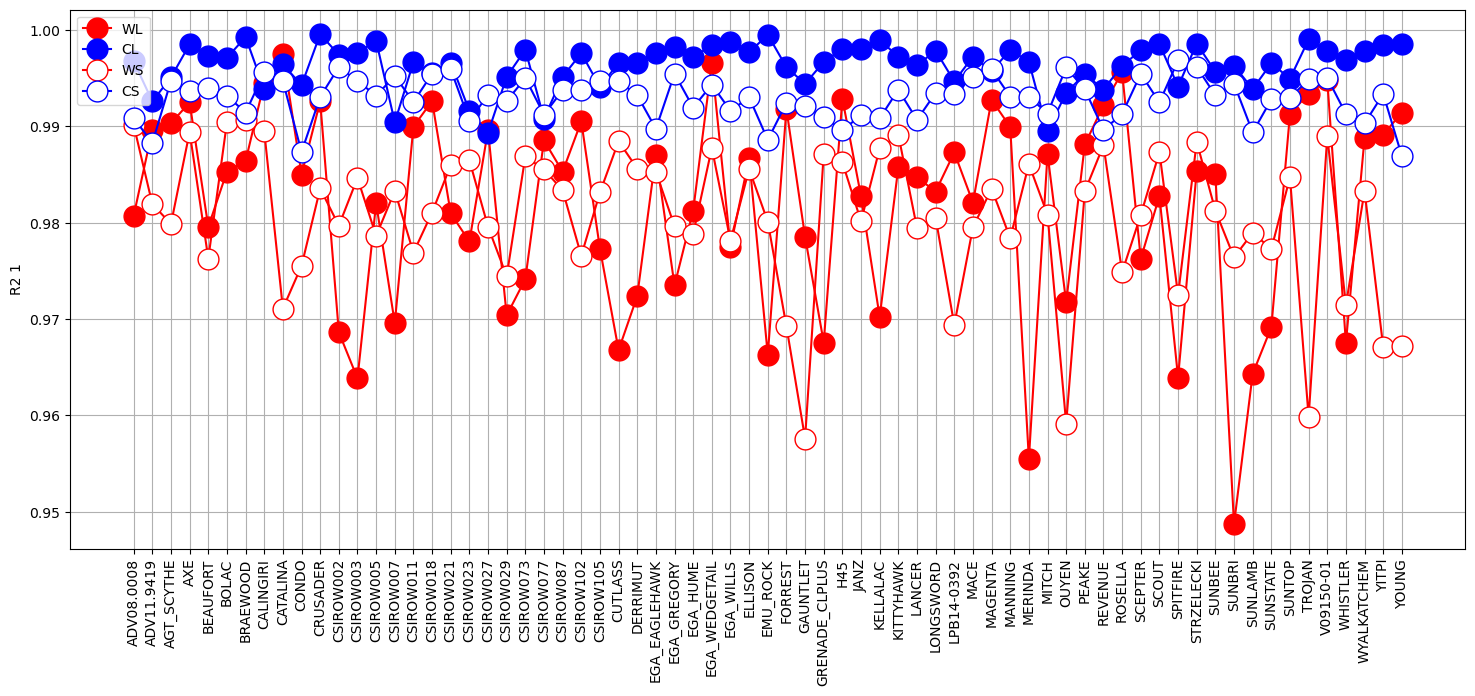

In [28]:
Graph = plt.figure(figsize=(18,7))
ax = Graph.add_subplot(1,1,1)
colpos = 0
for env in Envs:
    plt.plot(FittedPhyllochron.loc[env,'r2-1'],'-o',
             color = styles.loc[env,'Edge'],mec=styles.loc[env,'Edge'],mfc=styles.loc[env,'Fill'],label=env,ms=15)
    colpos +=1
plt.ylabel('R2 1')
plt.grid()
for tick in ax.get_xticklabels():
            tick.set_rotation(90)
plt.legend(loc=2)
Graph.patch.set_facecolor('white')

## Fits all look really good, so OK to use all data

## Next we fit regressions to the data between leaves 3 and 7 to determine base phyllochron (Phyllochron 2) for each treatment

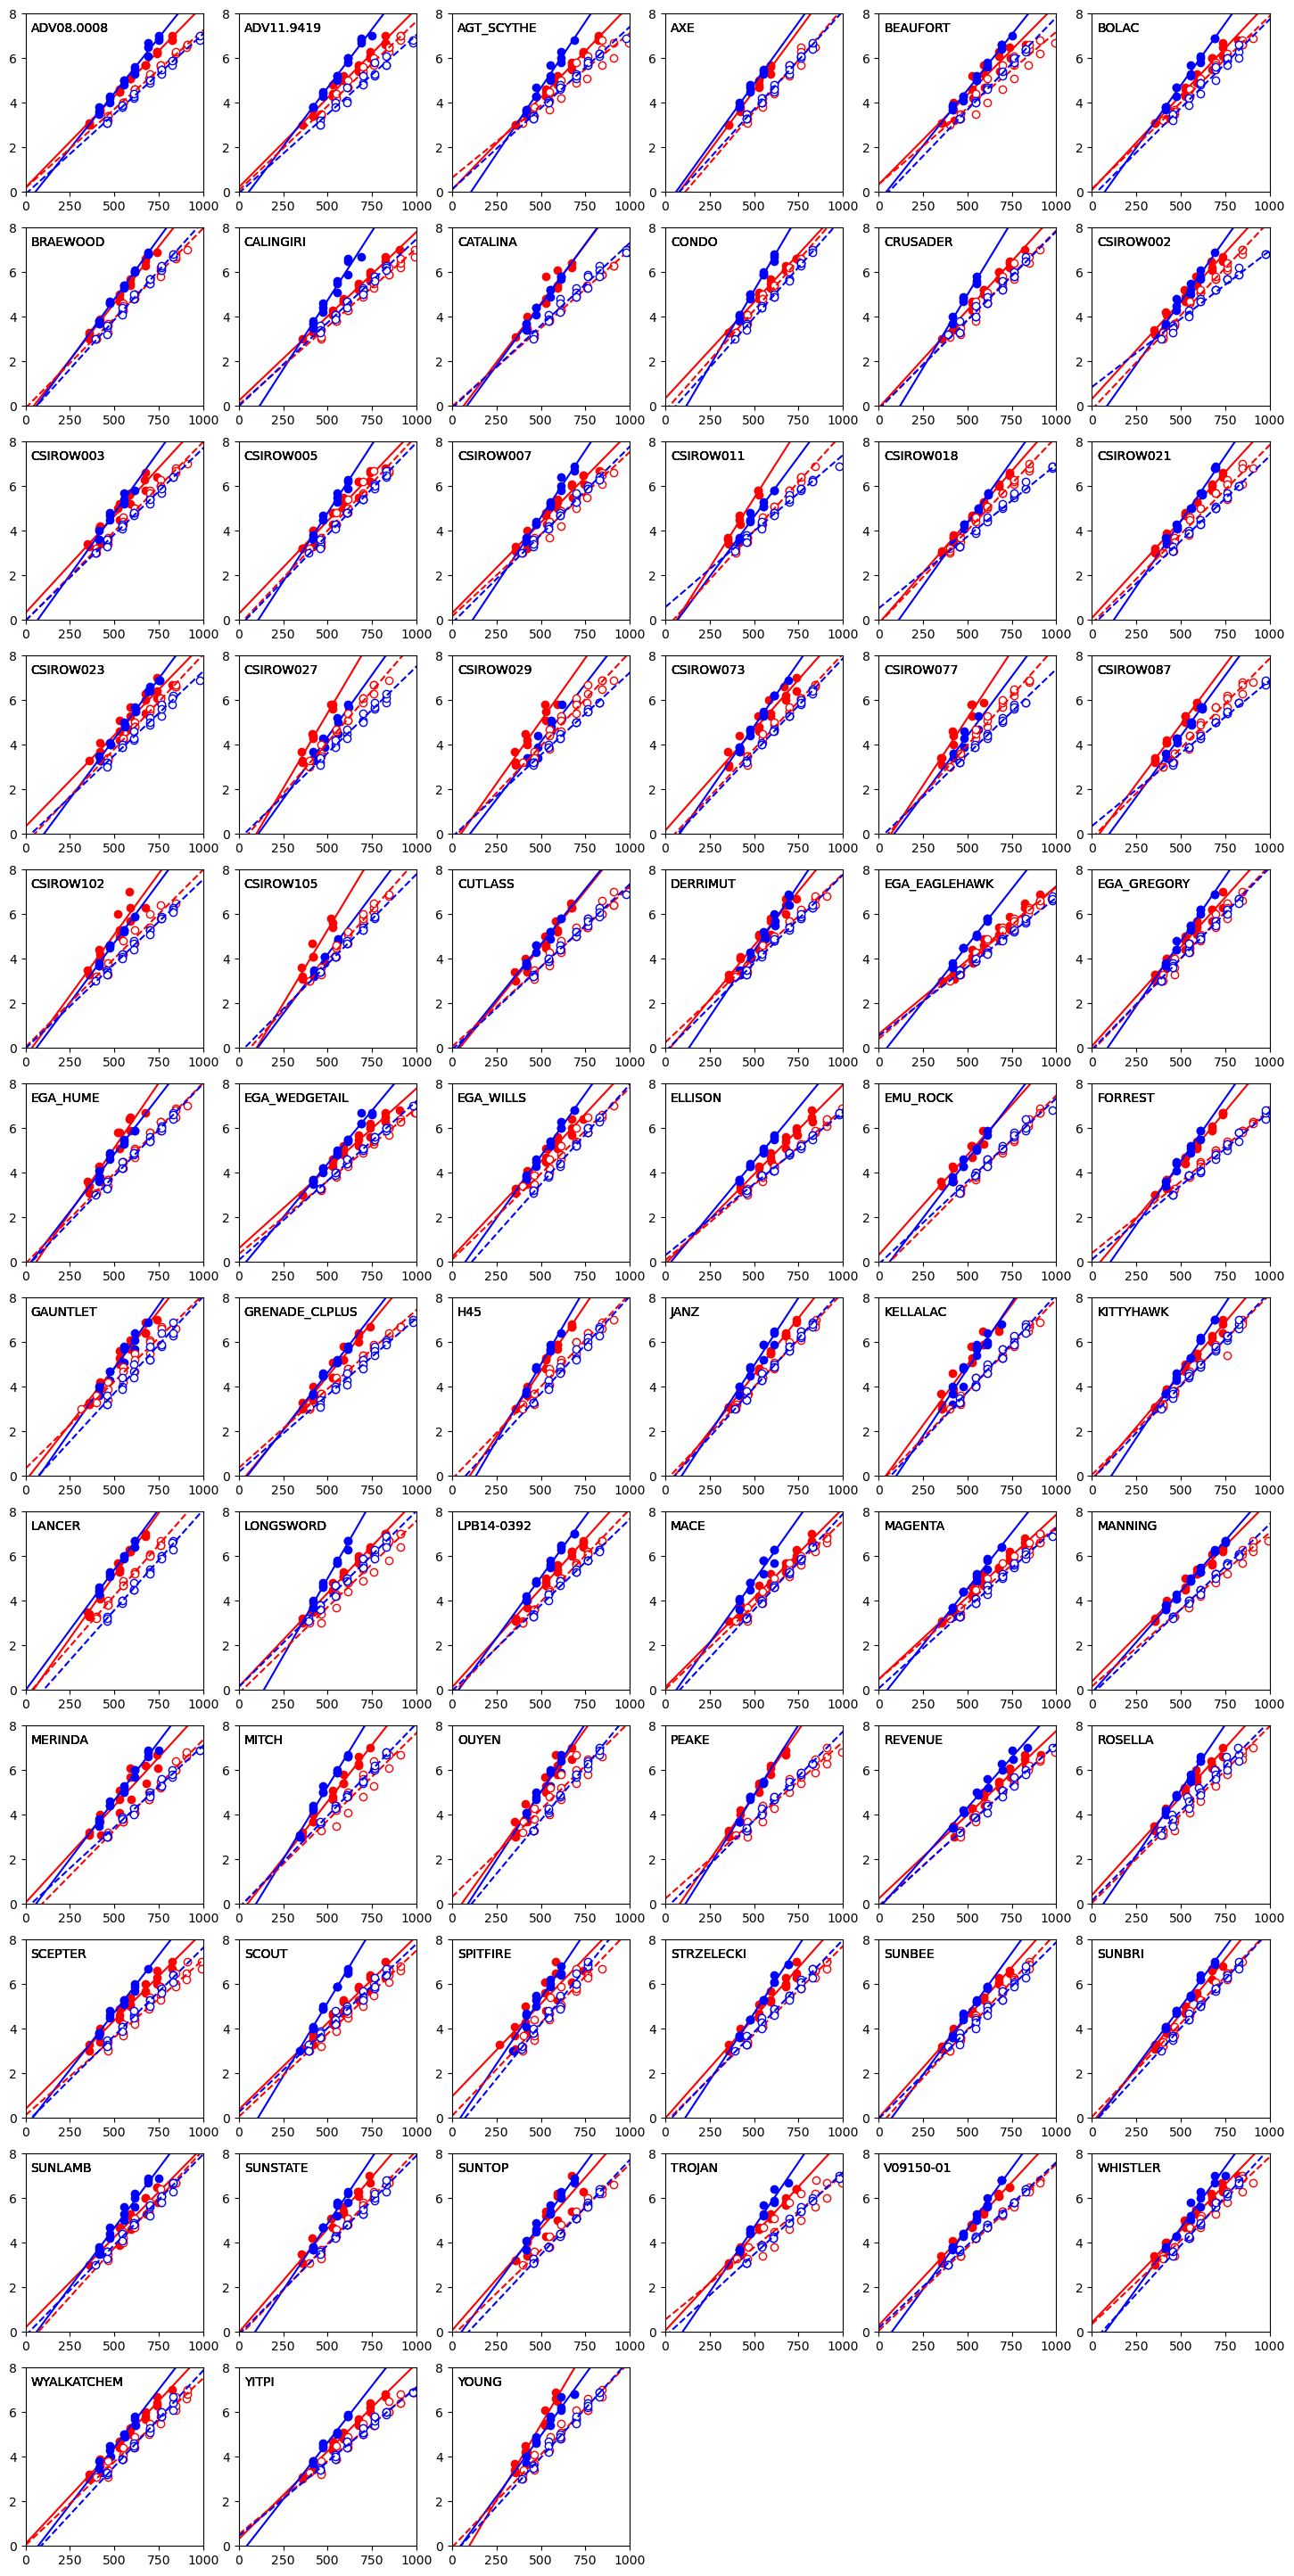

In [29]:
Graph = plt.figure(figsize=(18,40))
pos=1
for cul in Cults:
    ax = Graph.add_subplot(13,6,pos)
    pos+=1
    for env in Envs:
        base = (HSData.Value >= 3) & (HSData.Value <= 7) 
        FitNPlotPhyllochron(ax,base,'2',styles.loc[env,'Lines'])
    plt.ylim(0,8)
    plt.xlim(0,1000)
Graph.patch.set_facecolor('white')

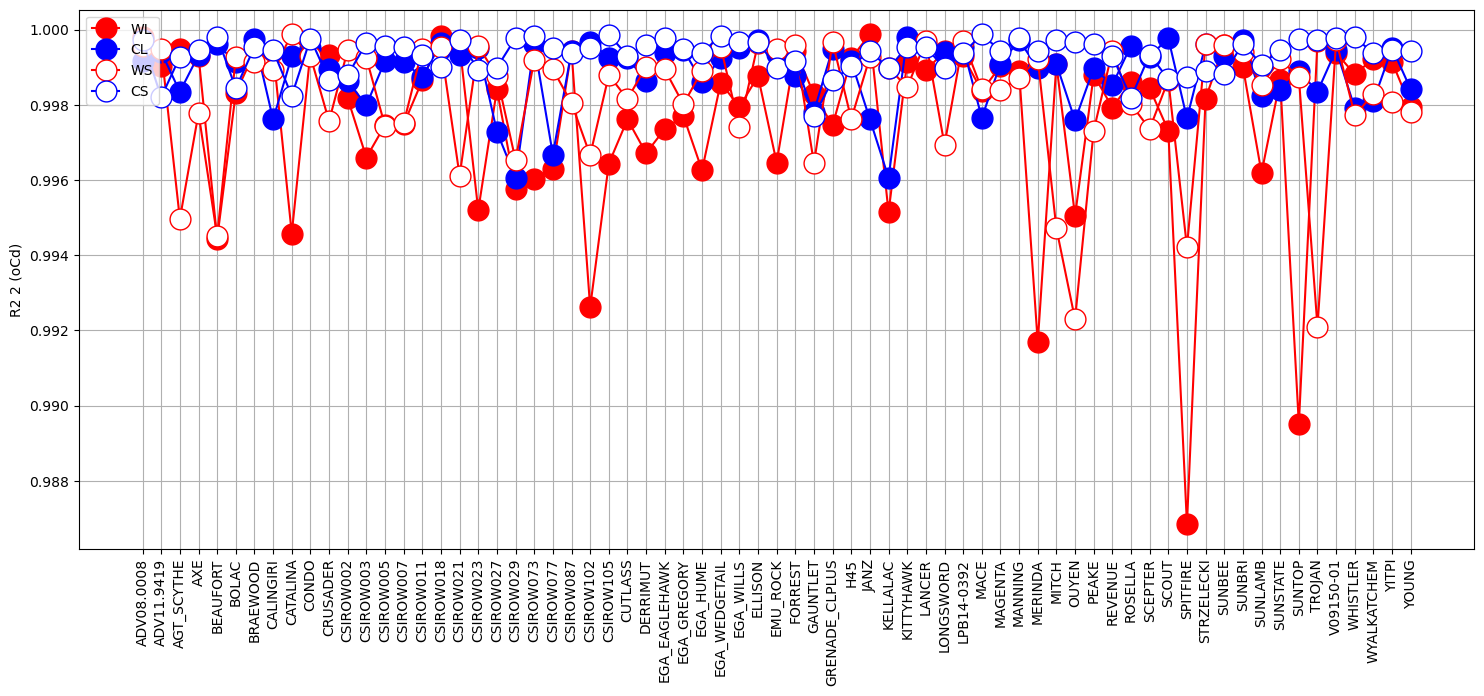

In [30]:
Graph = plt.figure(figsize=(18,7))
ax = Graph.add_subplot(1,1,1)
colpos = 0
for env in Envs:
    plt.plot(FittedPhyllochron.loc[env,'r2-2'],'-o',
             color = styles.loc[env,'Edge'],mec=styles.loc[env,'Edge'],mfc=styles.loc[env,'Fill'],label=env,ms=15)
    colpos +=1
plt.ylabel('R2 2 (oCd)')
plt.grid()
for tick in ax.get_xticklabels():
            tick.set_rotation(90)
plt.legend(loc=2)
Graph.patch.set_facecolor('white')

## Again fits all look really good and all data can be used

In [31]:
HSData.loc[(HSData.Value >= 7) & (HSData.Value <= 11),'Value'].loc[('WS','AXE')].count()

3

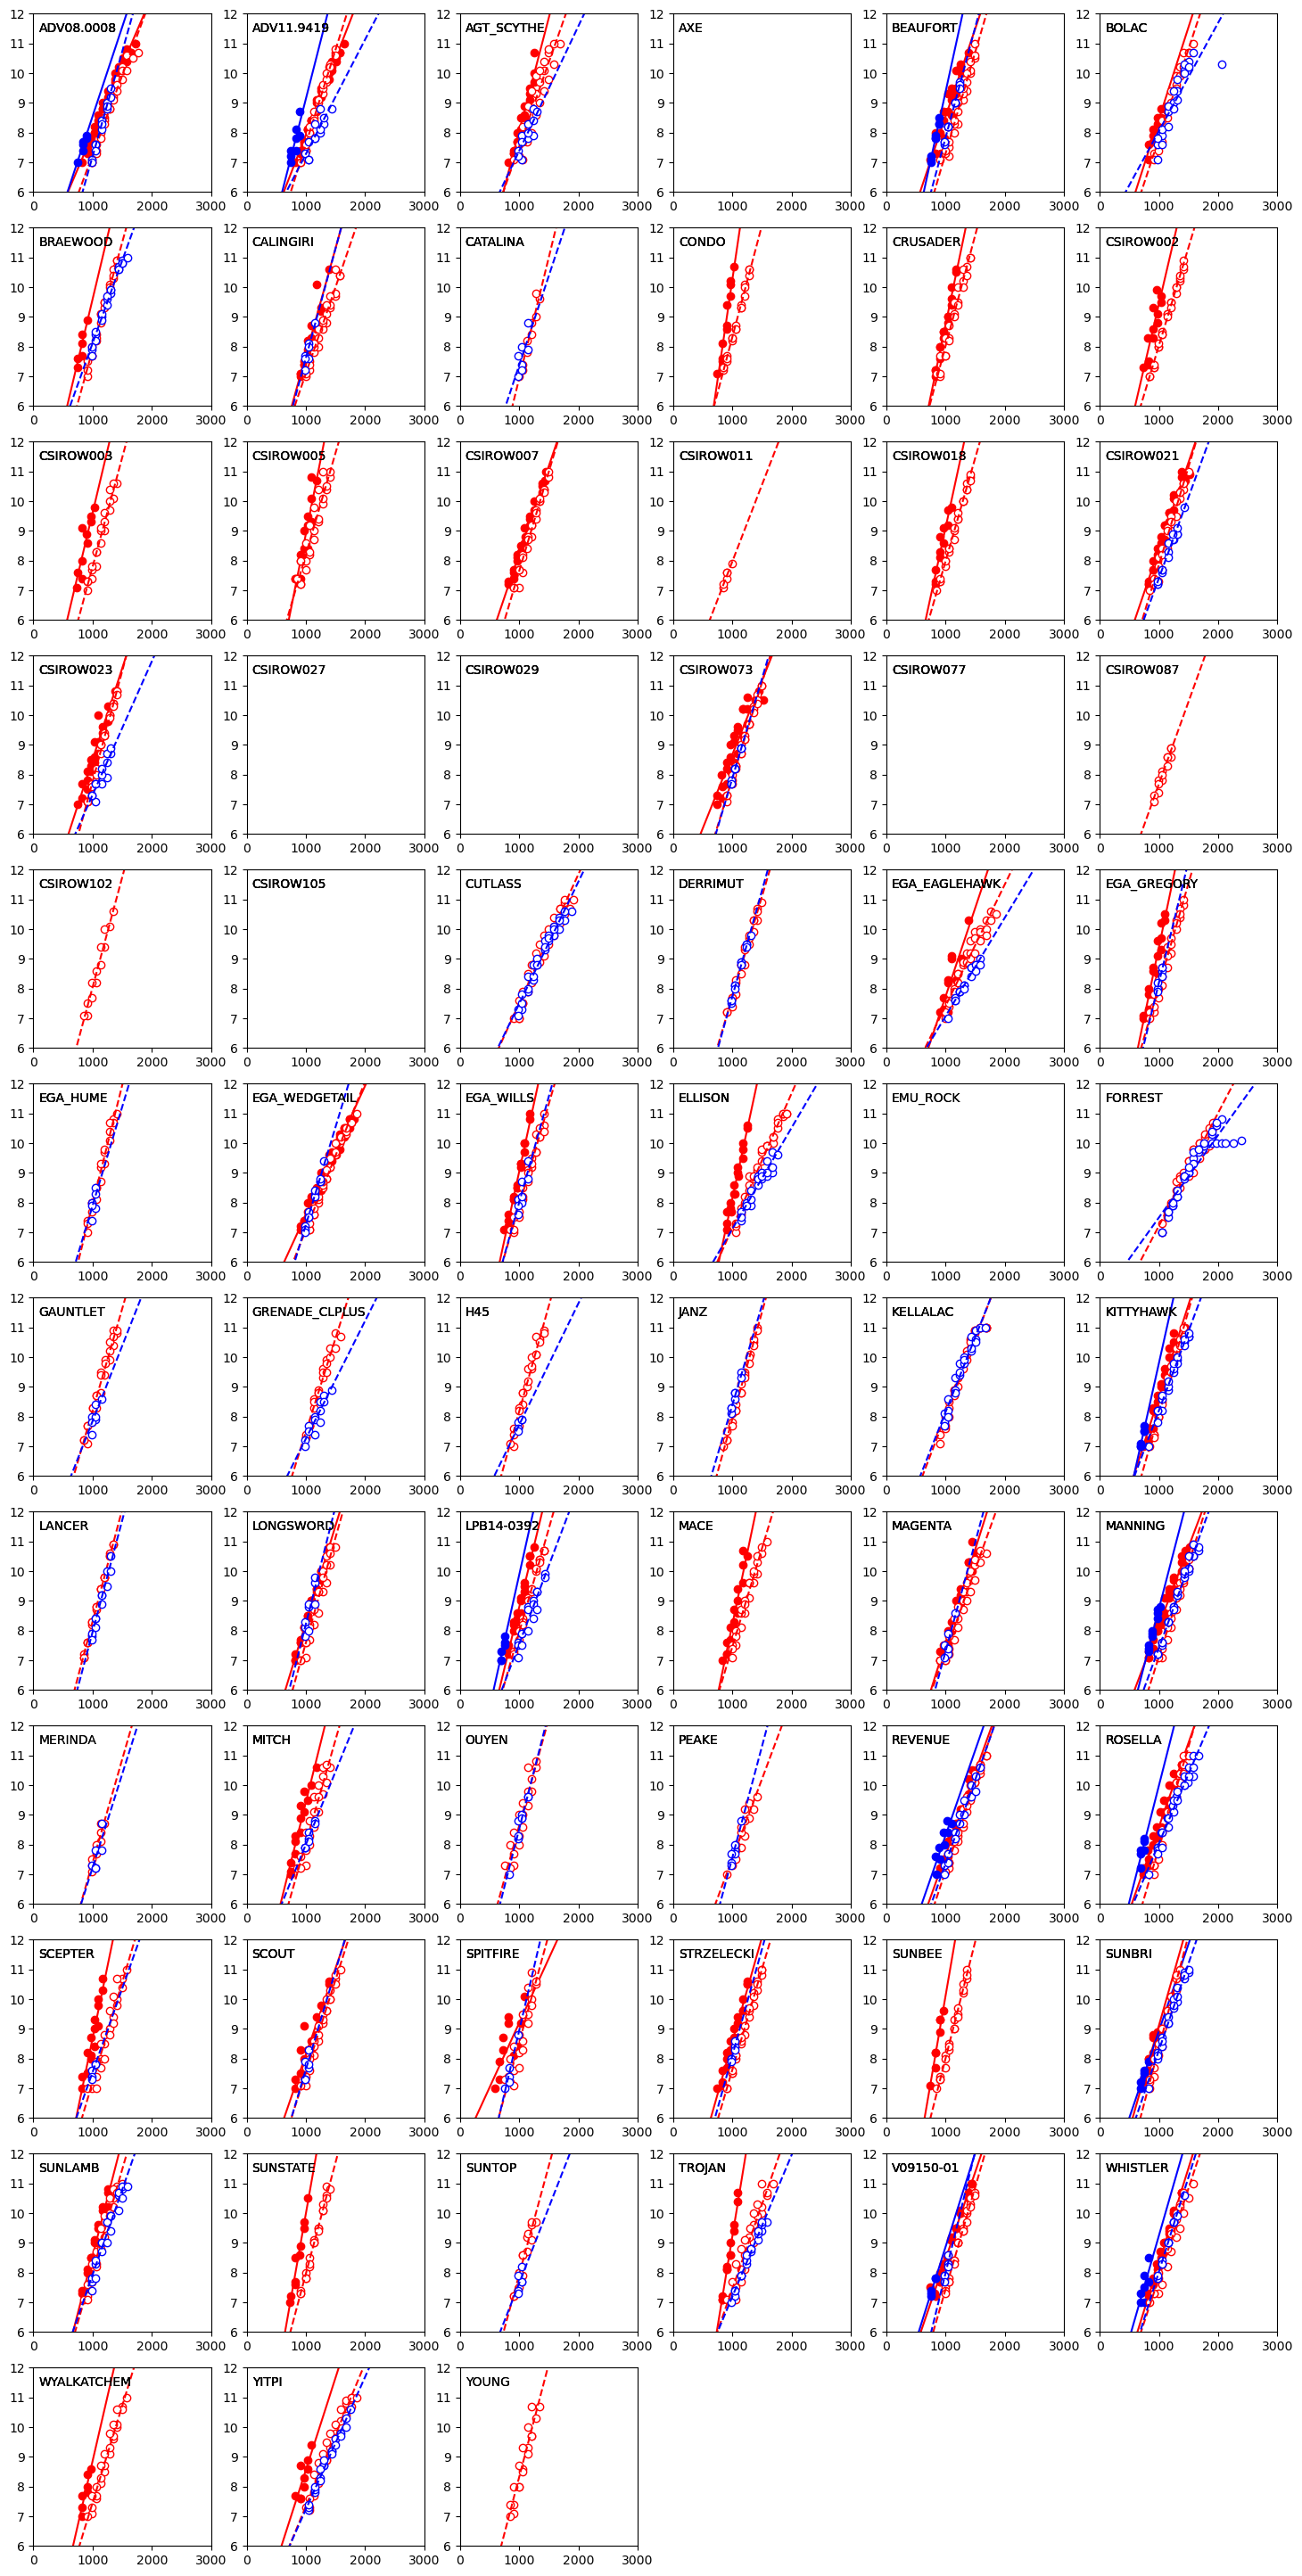

In [32]:
Graph = plt.figure(figsize=(18,40))
pos=1
for cul in Cults:
    ax = Graph.add_subplot(13,6,pos)
    pos+=1
    for env in Envs:
        try:
            base = (HSData.Value >= 7) & (HSData.Value <= 11) 
            if HSData.loc[base,'Value'].loc[(env,cul)].dropna().count()>4: 
                FitNPlotPhyllochron(ax,base,'3',styles.loc[env,'Lines'])
            else:
                FittedPhyllochron.loc[(env,cul),'Phyllochron3'] = np.nan
        except:
            FittedPhyllochron.loc[(env,cul),'Phyllochron3'] = np.nan
            plt.text(0.03,0.9,cul, transform=ax.transAxes)
    plt.ylim(6,12)
    plt.xlim(0,3000)
Graph.patch.set_facecolor('white')

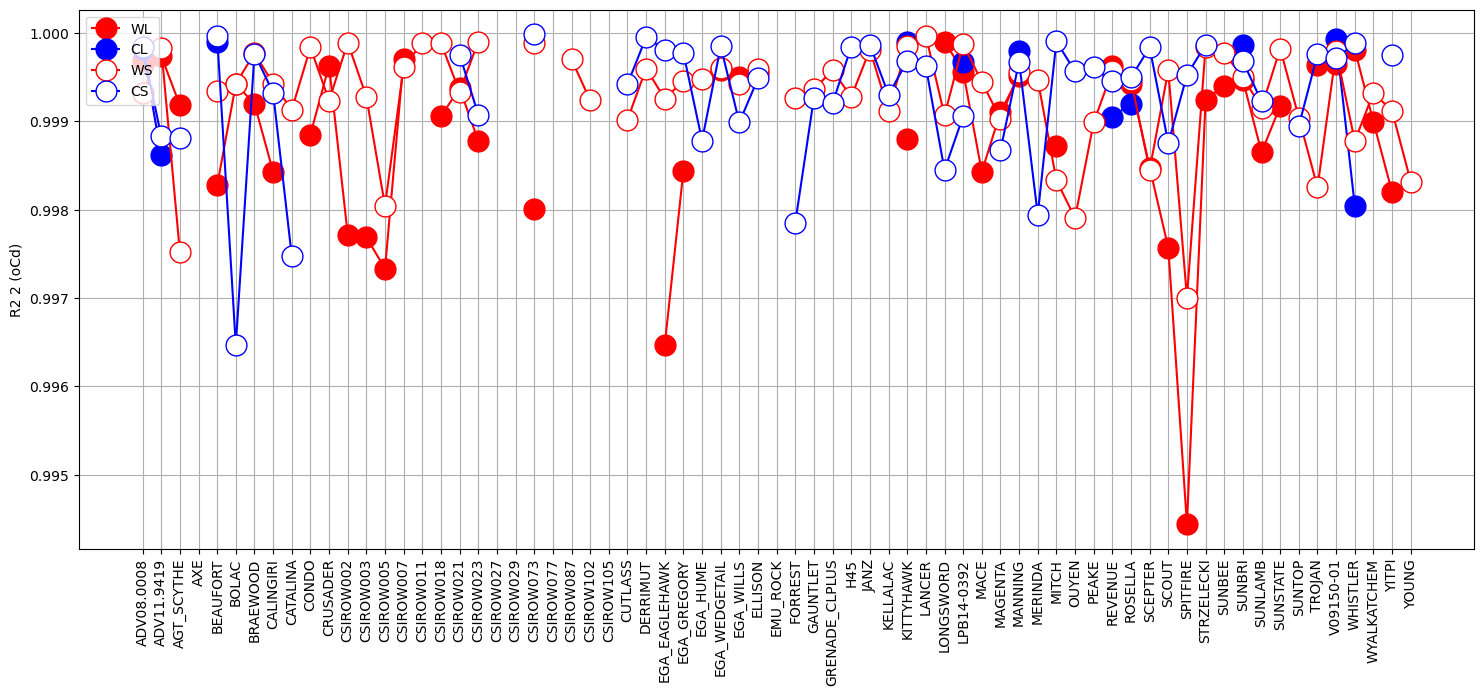

In [33]:
Graph = plt.figure(figsize=(18,7))
ax = Graph.add_subplot(1,1,1)
colpos = 0
for env in Envs:
    plt.plot(FittedPhyllochron.loc[env,'r2-3'],'-o',
             color = styles.loc[env,'Edge'],mec=styles.loc[env,'Edge'],mfc=styles.loc[env,'Fill'],label=env,ms=15)
    colpos +=1
plt.ylabel('R2 2 (oCd)')
plt.grid()
for tick in ax.get_xticklabels():
            tick.set_rotation(90)
plt.legend(loc=2)
Graph.patch.set_facecolor('white')

## All those where there was data beyond HS 7 gave a good fit but there are a number where the data range is quite small so these should be used with caution

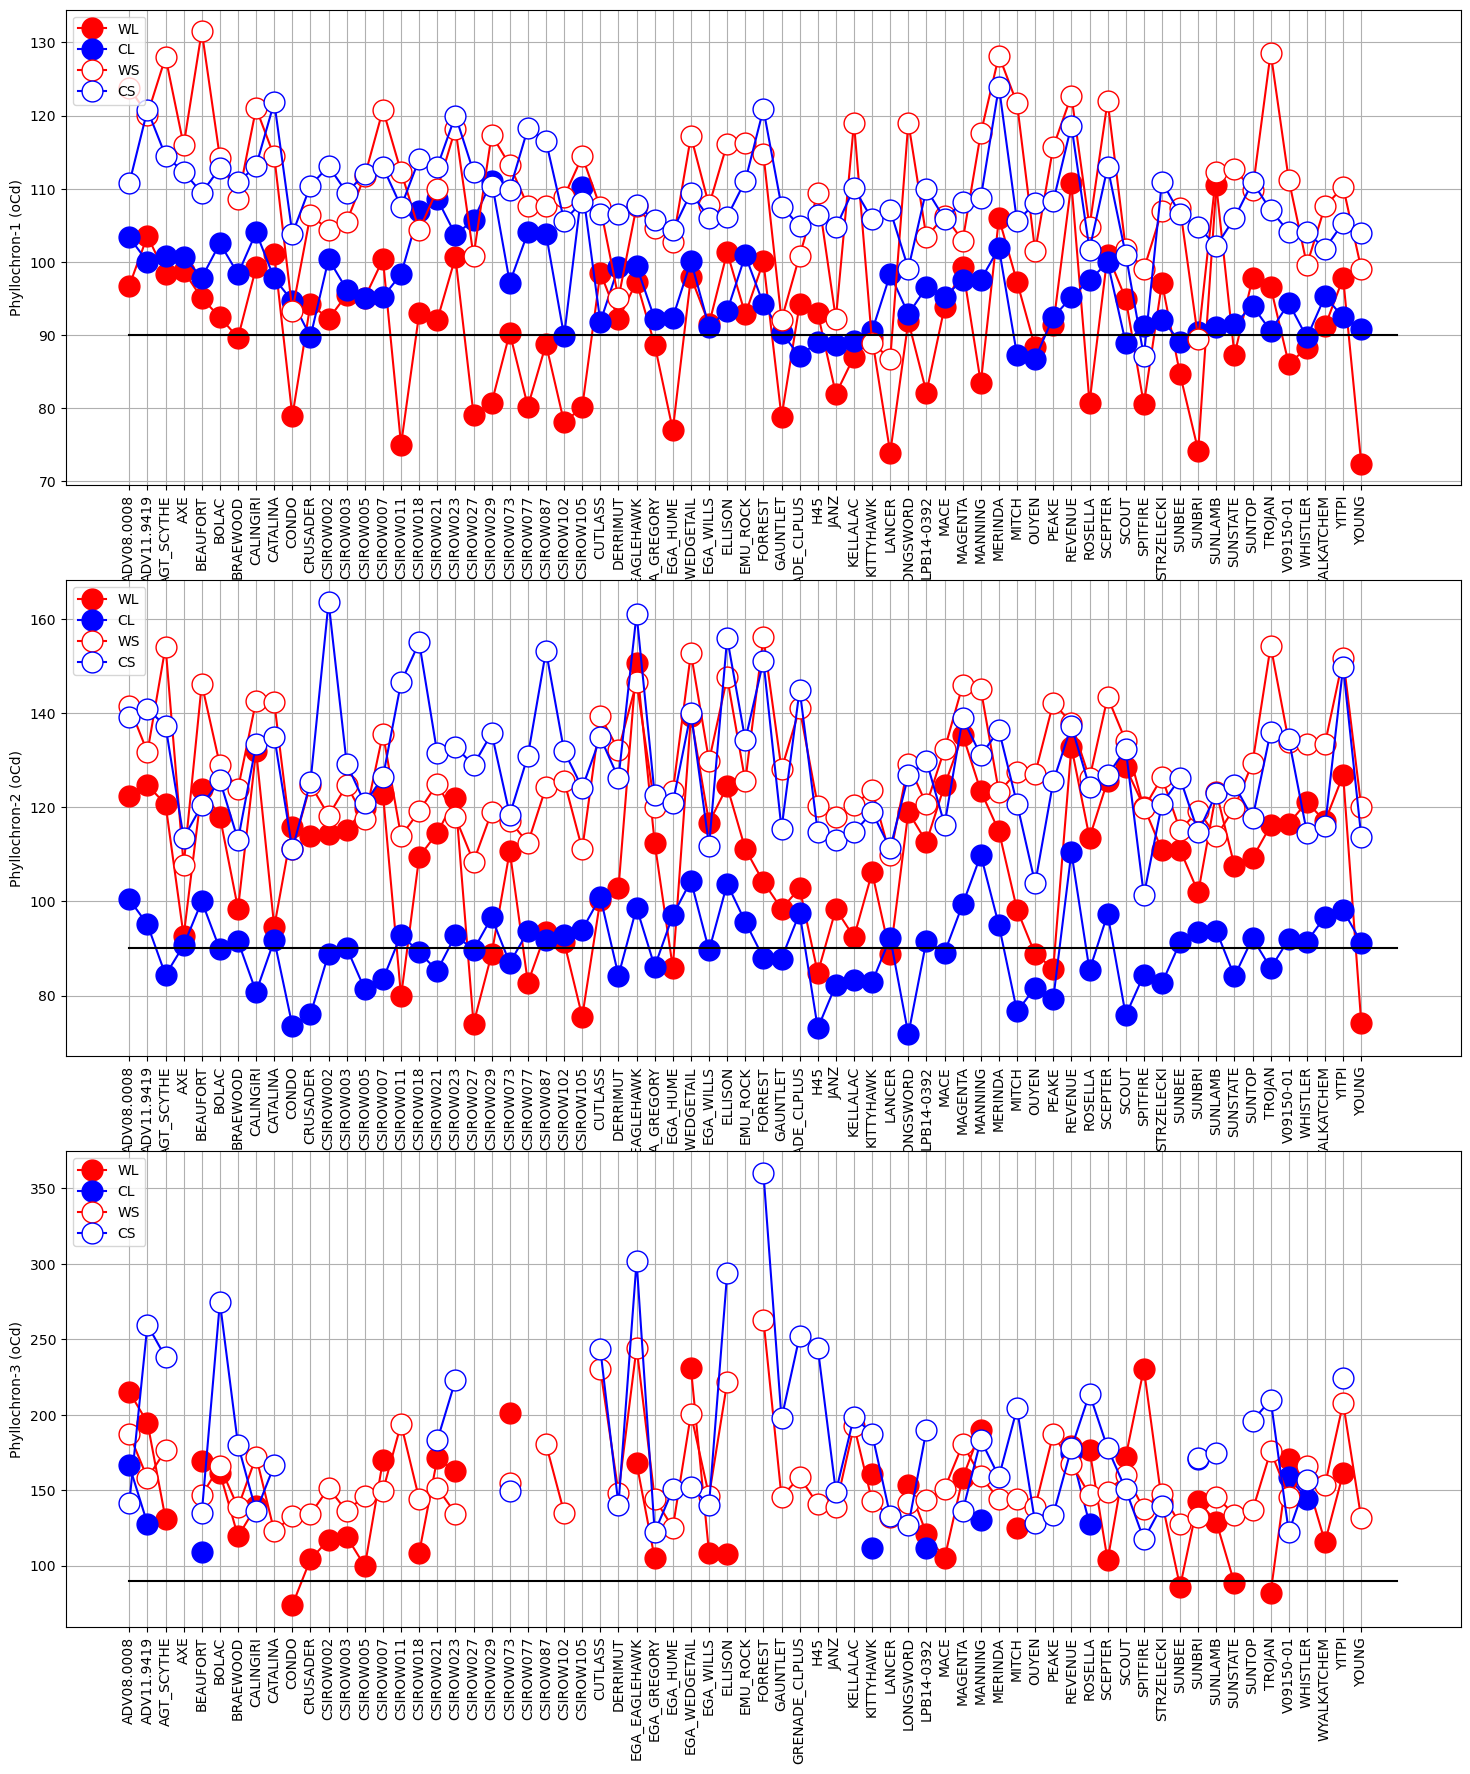

In [34]:
Graph = plt.figure(figsize=(18,21))
pos=1
for phyl in ['Phyllochron-1','Phyllochron-2','Phyllochron-3']:
    ax = Graph.add_subplot(3,1,pos)
    colpos = 0
    for env in Envs:
        plt.plot(FittedPhyllochron.loc[env,phyl],'-o',
                 color = styles.loc[env,'Edge'],mec=styles.loc[env,'Edge'],mfc=styles.loc[env,'Fill'],label=env,ms=15)
        colpos +=1
    plt.ylabel(phyl + ' (oCd)')
    plt.grid()
    for tick in ax.get_xticklabels():
                tick.set_rotation(90)
    plt.legend(loc=2)
    plt.plot([0,70],[90,90],'-',color='k')
    pos +=1
Graph.patch.set_facecolor('white')

## Clearly some treatment responses for phyllochron so lets calculte genotype responses

In [35]:
GenoParams = pd.DataFrame(index = Cults)

In [36]:
def CalcDif(cul,t1,t2,phase):
    ### Calculate the t statistic
    top = np.absolute(FittedPhyllochron.loc[(t1,cul),'Phyllochron-'+phase] - FittedPhyllochron.loc[(t2,cul),'Phyllochron-'+phase])
    bot = np.sqrt(FittedPhyllochron.loc[(t1,cul),'SE-'+phase]**2 + FittedPhyllochron.loc[(t2,cul),'SE-'+phase]**2)
    t = top/bot
    ## Calcualte probability from t (https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/)
    degFre = FittedPhyllochron.loc[(t1,cul),'n-'+phase] + FittedPhyllochron.loc[(t2,cul),'n-'+phase] - 2
    p = (1 - stats.t.cdf(t,df=degFre)) * 2 ## assume 2 tailed, not sure it this is a correct assumption
    if p <= 0.05:
        return FittedPhyllochron.loc[(t1,cul),'Phyllochron-'+phase] - FittedPhyllochron.loc[(t2,cul),'Phyllochron-'+phase]
    else:
        return 0.0

In [37]:
for phase in ['1','2','3']:
    for cul in Cults:
        GenoParams.loc[cul,'PhylloSVnsens'+phase] = CalcDif(cul,'WS','CS',phase)
    for cul in Cults:
        GenoParams.loc[cul,'PhylloLVnsens'+phase] = CalcDif(cul,'WL','CL',phase)
    for cul in Cults:
        GenoParams.loc[cul,'PhylloVPPsens'+phase] = CalcDif(cul,'CS','CL',phase)
    for cul in Cults:
        GenoParams.loc[cul,'PhylloNPPsens'+phase] = CalcDif(cul,'WS','WL',phase)
    GenoParams.loc[:,'Phyllochron-'+phase] = FittedPhyllochron.loc['CL','Phyllochron-'+phase].reindex(GenoParams.index)
GenoParams.loc[:,'PhylloPPSens1'] = FittedPhyllochron.loc['CS','Phyllochron-1']/FittedPhyllochron.loc['CL','Phyllochron-1']
GenoParams.loc[:,'PhylloPPSens2'] = FittedPhyllochron.loc['CS','Phyllochron-2']/FittedPhyllochron.loc['CL','Phyllochron-2']
GenoParams.loc[:,'PhylloPPSens3'] = FittedPhyllochron.loc['WS','Phyllochron-3']/FittedPhyllochron.loc['WL','Phyllochron-3']
GenoParams.loc[:,'PhylloRatio1'] = FittedPhyllochron.loc['CL','Phyllochron-1']/FittedPhyllochron.loc['CL','Phyllochron-2']
GenoParams.loc[:,'PhylloRatio3'] = FittedPhyllochron.loc['CL','Phyllochron-3']/FittedPhyllochron.loc['CL','Phyllochron-2']

## Graph responses

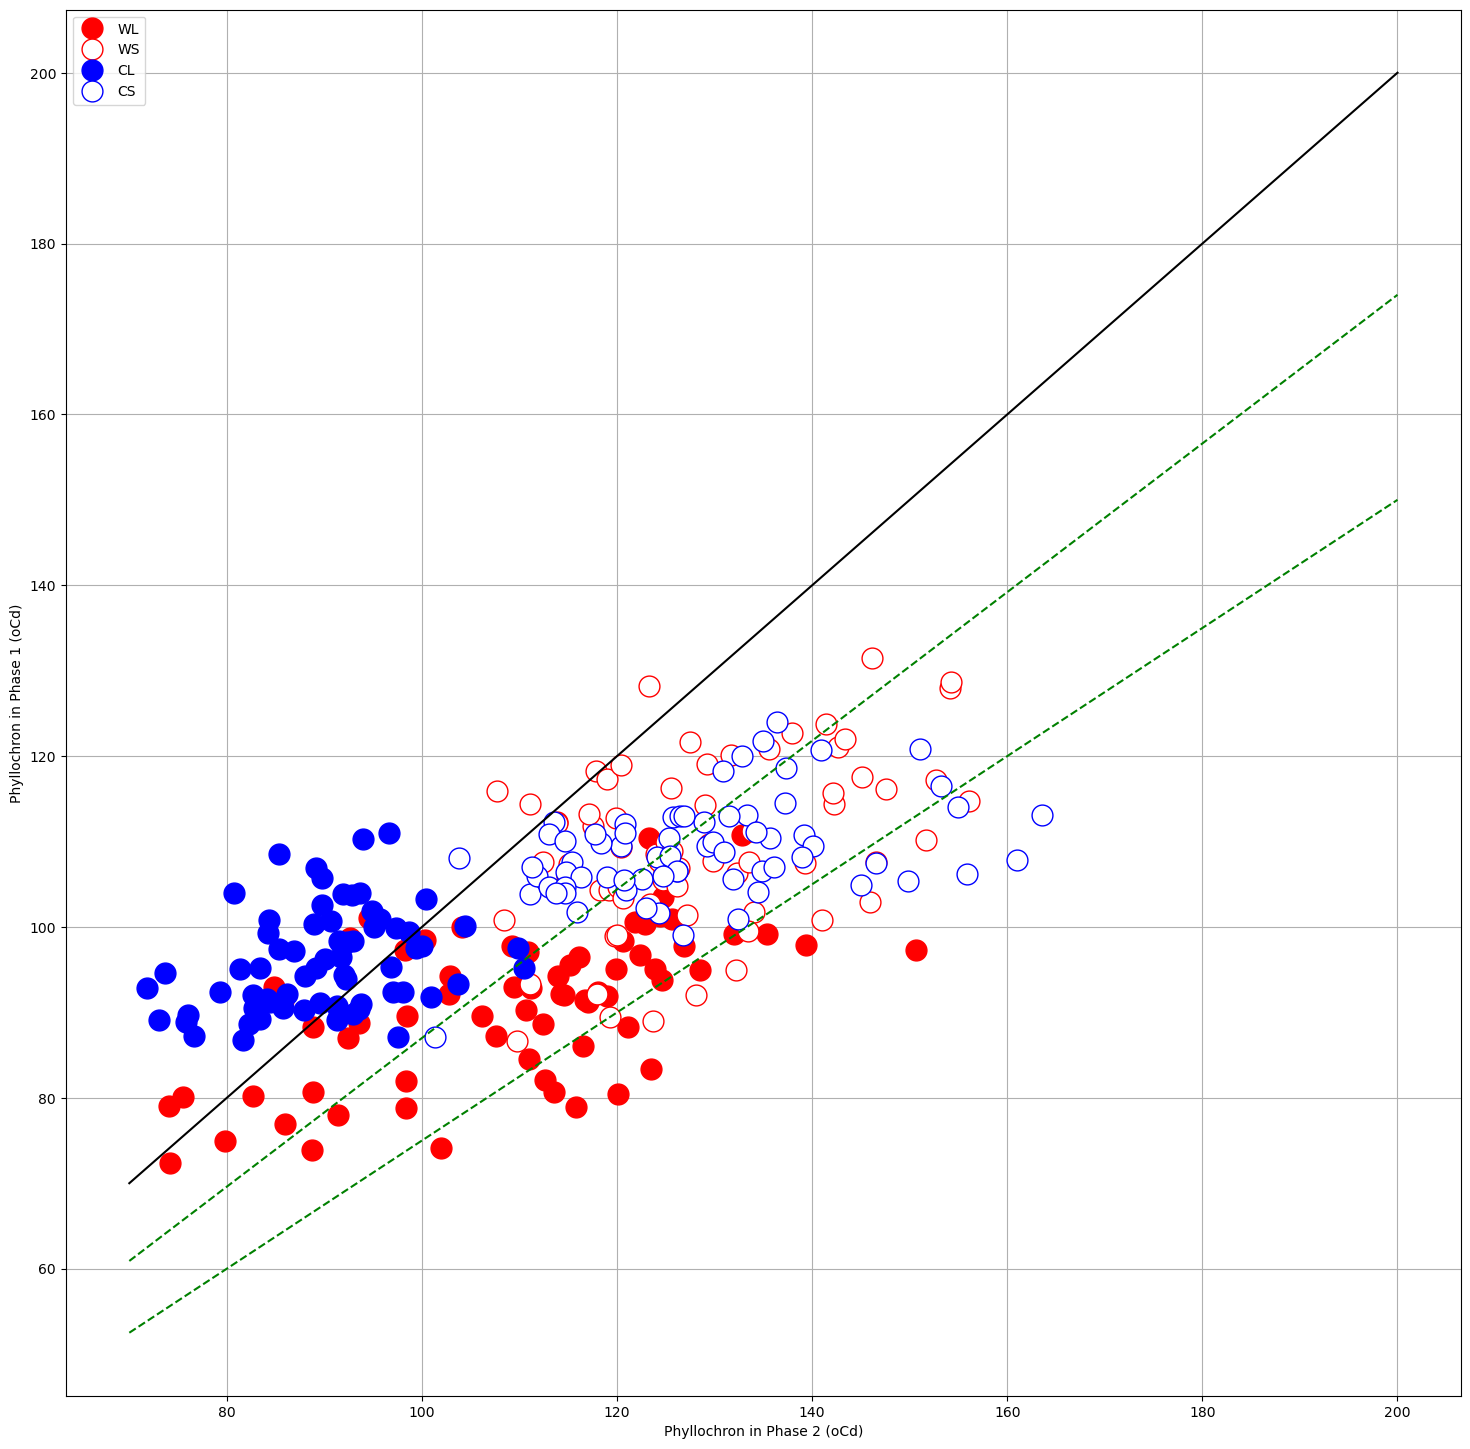

In [38]:
Graph = plt.figure(figsize=(18,18))
pos=1
ax = Graph.add_subplot(1,1,pos)
colpos = 0
for env in ['WL','WS','CL','CS']:
    plt.plot(FittedPhyllochron.loc[env,'Phyllochron-2'],
             FittedPhyllochron.loc[env,'Phyllochron-1'],
             'o',color = styles.loc[env,'Edge'],mec=styles.loc[env,'Edge'],mfc=styles.loc[env,'Fill'],label=env,ms=15)
    colpos +=1
plt.ylabel('Phyllochron in Phase 1 (oCd)')
plt.xlabel('Phyllochron in Phase 2 (oCd)')
plt.plot([70,200],[70,200],'-',color='k')
plt.plot([70,200],[70*.75,200*.75],'--',color='g')
plt.plot([70,200],[70*.87,200*.87],'--',color='g')
plt.grid()
plt.legend(loc=2)
pos+=1
Graph.patch.set_facecolor('white')

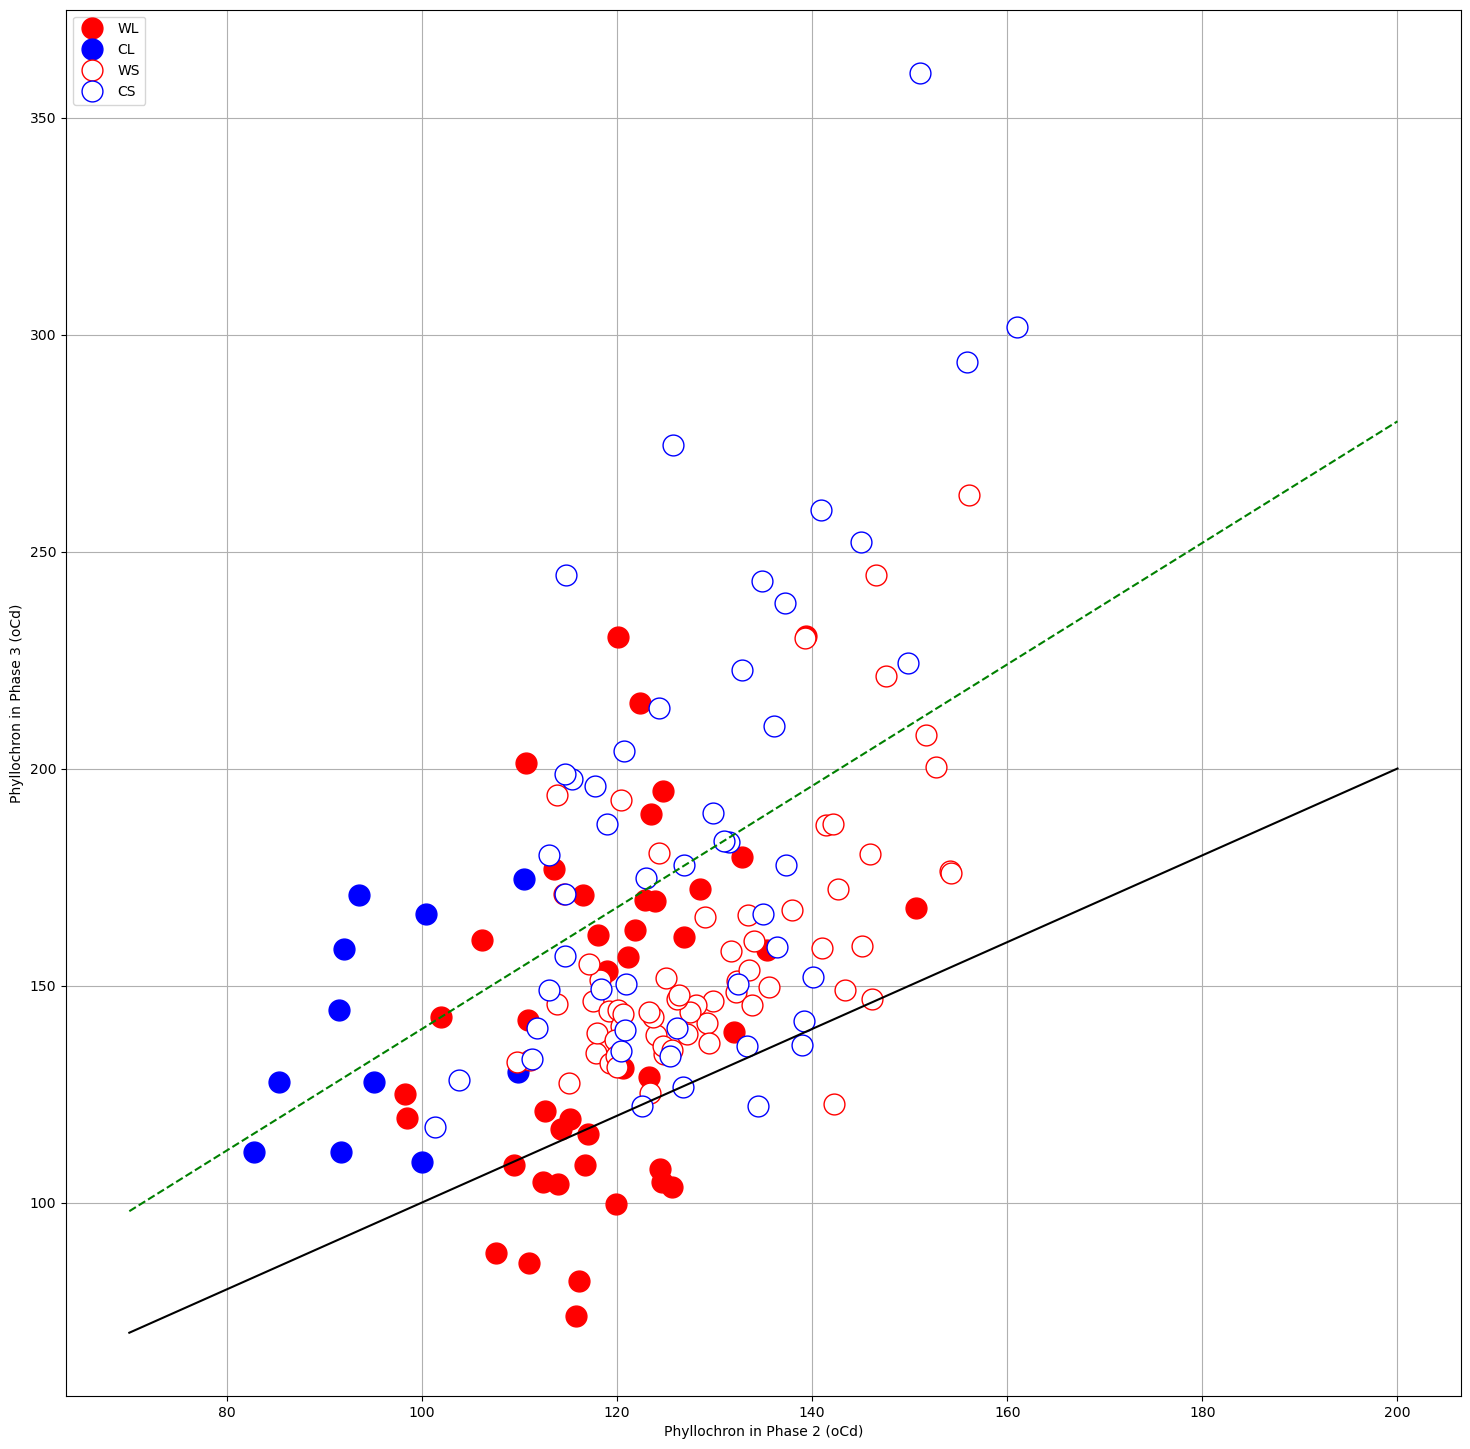

In [39]:
Graph = plt.figure(figsize=(18,18))
pos=1
ax = Graph.add_subplot(1,1,pos)
colpos = 0
for env in Envs:
    plt.plot(FittedPhyllochron.loc[env,'Phyllochron-2'],
             FittedPhyllochron.loc[env,'Phyllochron-3'],
             'o',color = styles.loc[env,'Edge'],mec=styles.loc[env,'Edge'],mfc=styles.loc[env,'Fill'],label=env,ms=15)
    colpos +=1
plt.ylabel('Phyllochron in Phase 3 (oCd)')
plt.xlabel('Phyllochron in Phase 2 (oCd)')
plt.plot([70,200],[70,200],'-',color='k')
plt.plot([70,200],[70*1.4,200*1.4],'--',color='g')
plt.grid()
plt.legend(loc=2)
pos+=1
Graph.patch.set_facecolor('white')

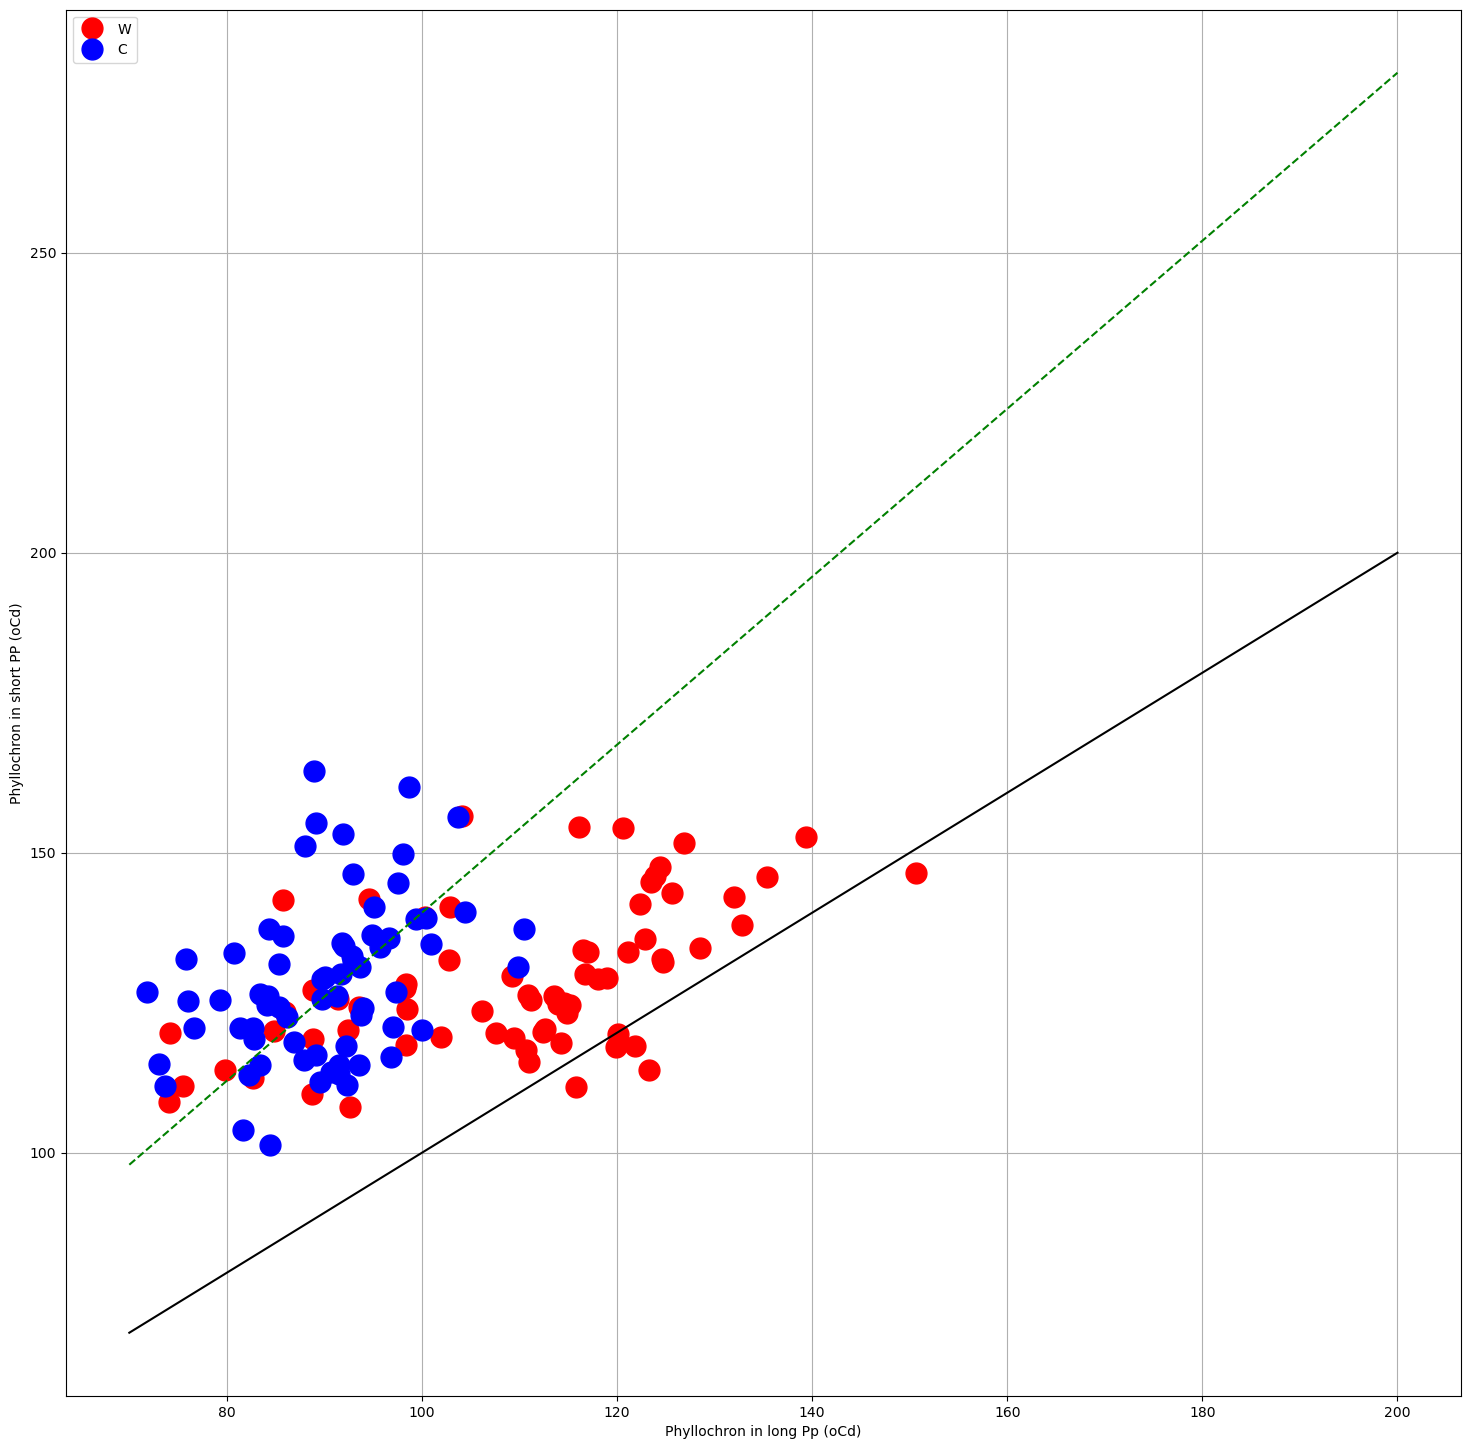

In [40]:
Graph = plt.figure(figsize=(18,18))
pos=1
ax = Graph.add_subplot(1,1,pos)
colpos = 0
for v in ['W','C']:
    plt.plot(FittedPhyllochron.loc[v+'L','Phyllochron-2'],
             FittedPhyllochron.loc[v+'S','Phyllochron-2'],
             'o',color = colors[colpos],mec=colors[colpos],mfc=fills[colpos],label=v,ms=15)
    colpos +=1
plt.ylabel('Phyllochron in short PP (oCd)')
plt.xlabel('Phyllochron in long Pp (oCd)')
plt.plot([70,200],[70,200],'-',color='k')
plt.plot([70,200],[70*1.4,200*1.4],'--',color='g')
plt.grid()
plt.legend(loc=2)
pos+=1
Graph.patch.set_facecolor('white')

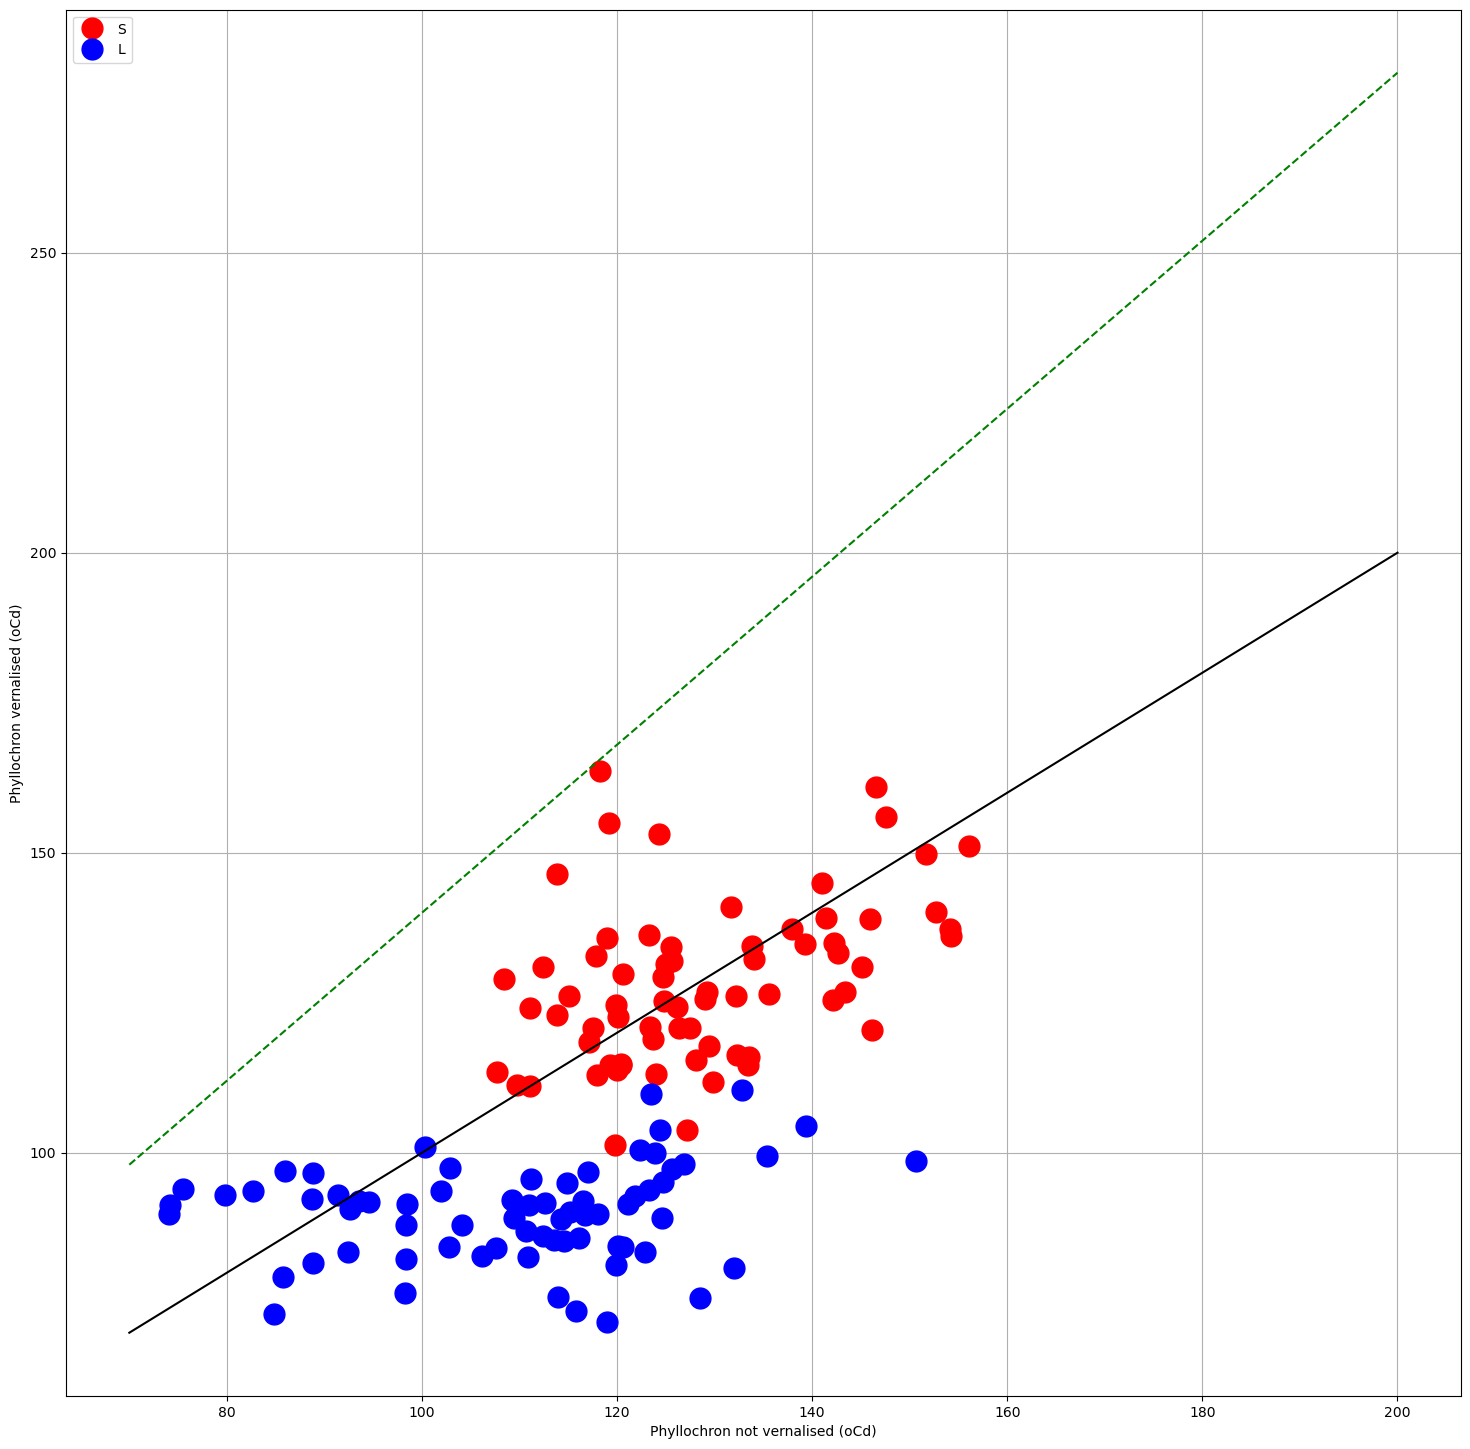

In [41]:
Graph = plt.figure(figsize=(18,18))
pos=1
ax = Graph.add_subplot(1,1,pos)
colpos = 0
for p in ['S','L']:
    plt.plot(FittedPhyllochron.loc['W'+p,'Phyllochron-2'],
             FittedPhyllochron.loc['C'+p,'Phyllochron-2'],
             'o',color = colors[colpos],mec=colors[colpos],mfc=fills[colpos],label=p,ms=15)
    colpos +=1
plt.ylabel('Phyllochron vernalised (oCd)')
plt.xlabel('Phyllochron not vernalised (oCd)')
plt.plot([70,200],[70,200],'-',color='k')
plt.plot([70,200],[70*1.4,200*1.4],'--',color='g')
plt.grid()
plt.legend(loc=2)
pos+=1
Graph.patch.set_facecolor('white')

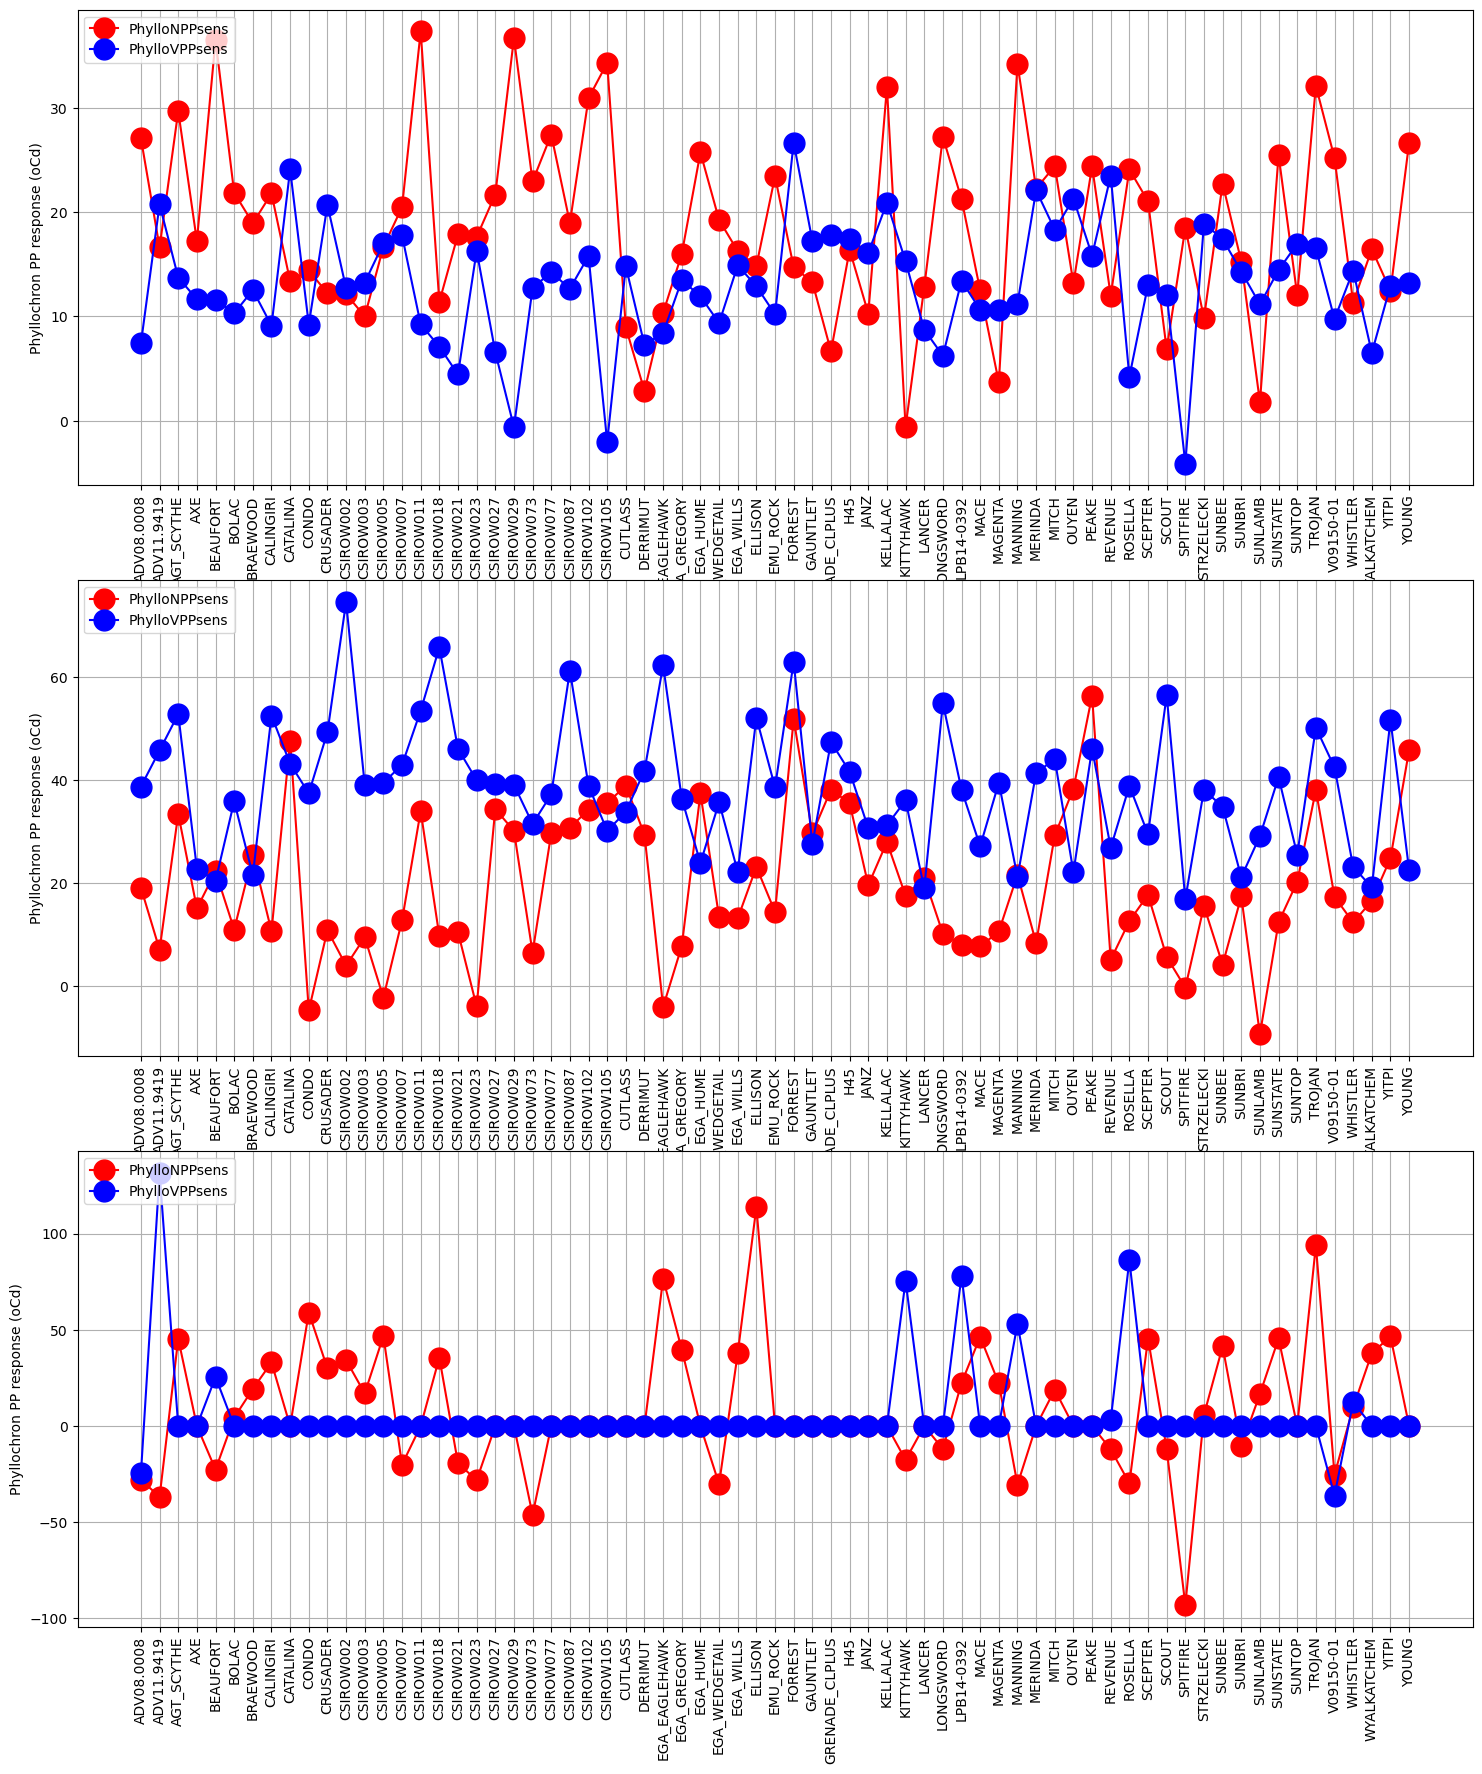

In [42]:
Graph = plt.figure(figsize=(18,21))
pos=1
for phase in ['1','2','3']:
    ax = Graph.add_subplot(3,1,pos)
    colpos = 0
    for Resp in ['PhylloNPPsens','PhylloVPPsens']:
        plt.plot(GenoParams.loc[:,Resp+phase],'-o',color = colors[colpos],mec=colors[colpos],mfc=fills[colpos],label=Resp,ms=15)
        colpos +=1
    plt.ylabel('Phyllochron PP response (oCd)')
    plt.grid()
    for tick in ax.get_xticklabels():
                tick.set_rotation(90)
    plt.legend(loc=2)
    pos+=1
Graph.patch.set_facecolor('white')

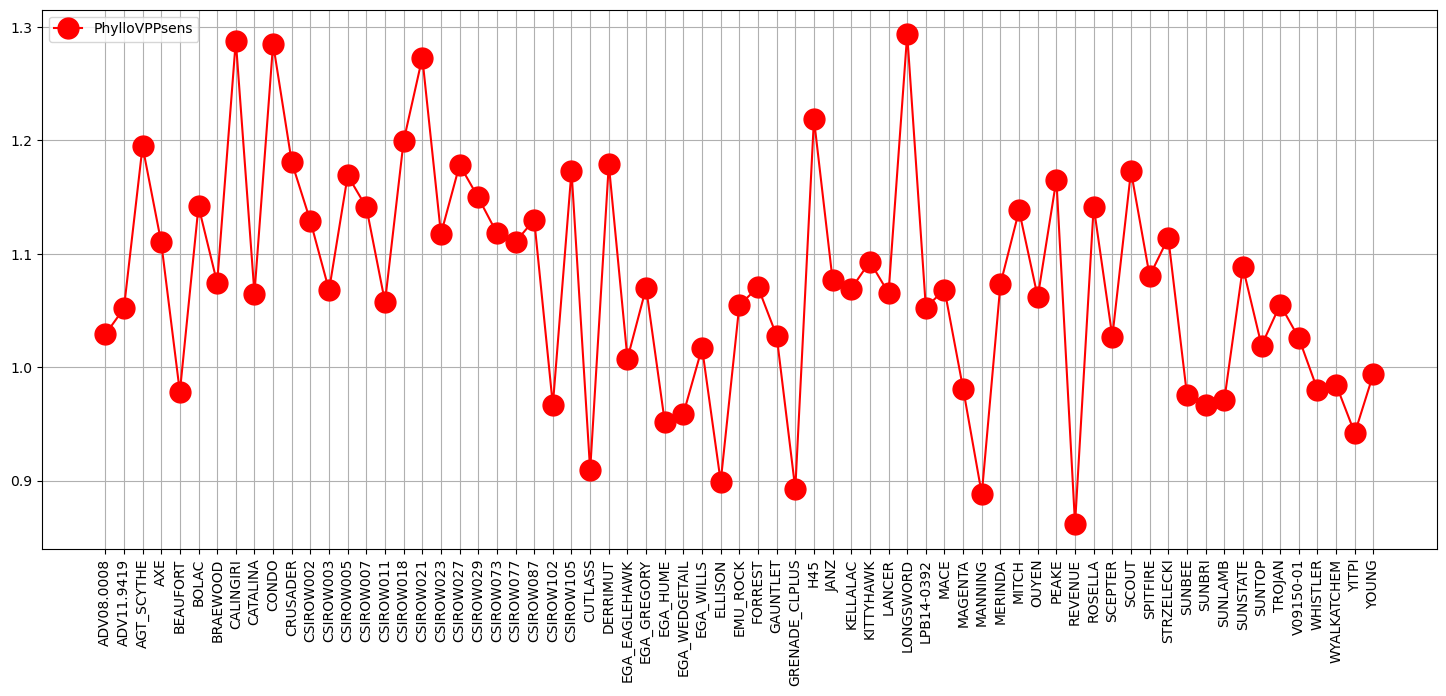

In [43]:
Graph = plt.figure(figsize=(18,7))
pos=1
ax = Graph.add_subplot(1,1,pos)
colpos = 0
plt.plot(GenoParams.loc[:,'PhylloRatio1'],'-o',color = colors[colpos],mec=colors[colpos],mfc=fills[colpos],label=Resp,ms=15)
plt.grid()
for tick in ax.get_xticklabels():
            tick.set_rotation(90)
plt.legend(loc=2)
Graph.patch.set_facecolor('white')

### Under full vernalisation there is a clear photoperiod response for all but one cultivar
### Without vernalisation some cultivars show similar photoperiod sensitivity as under vernalisation but some are less

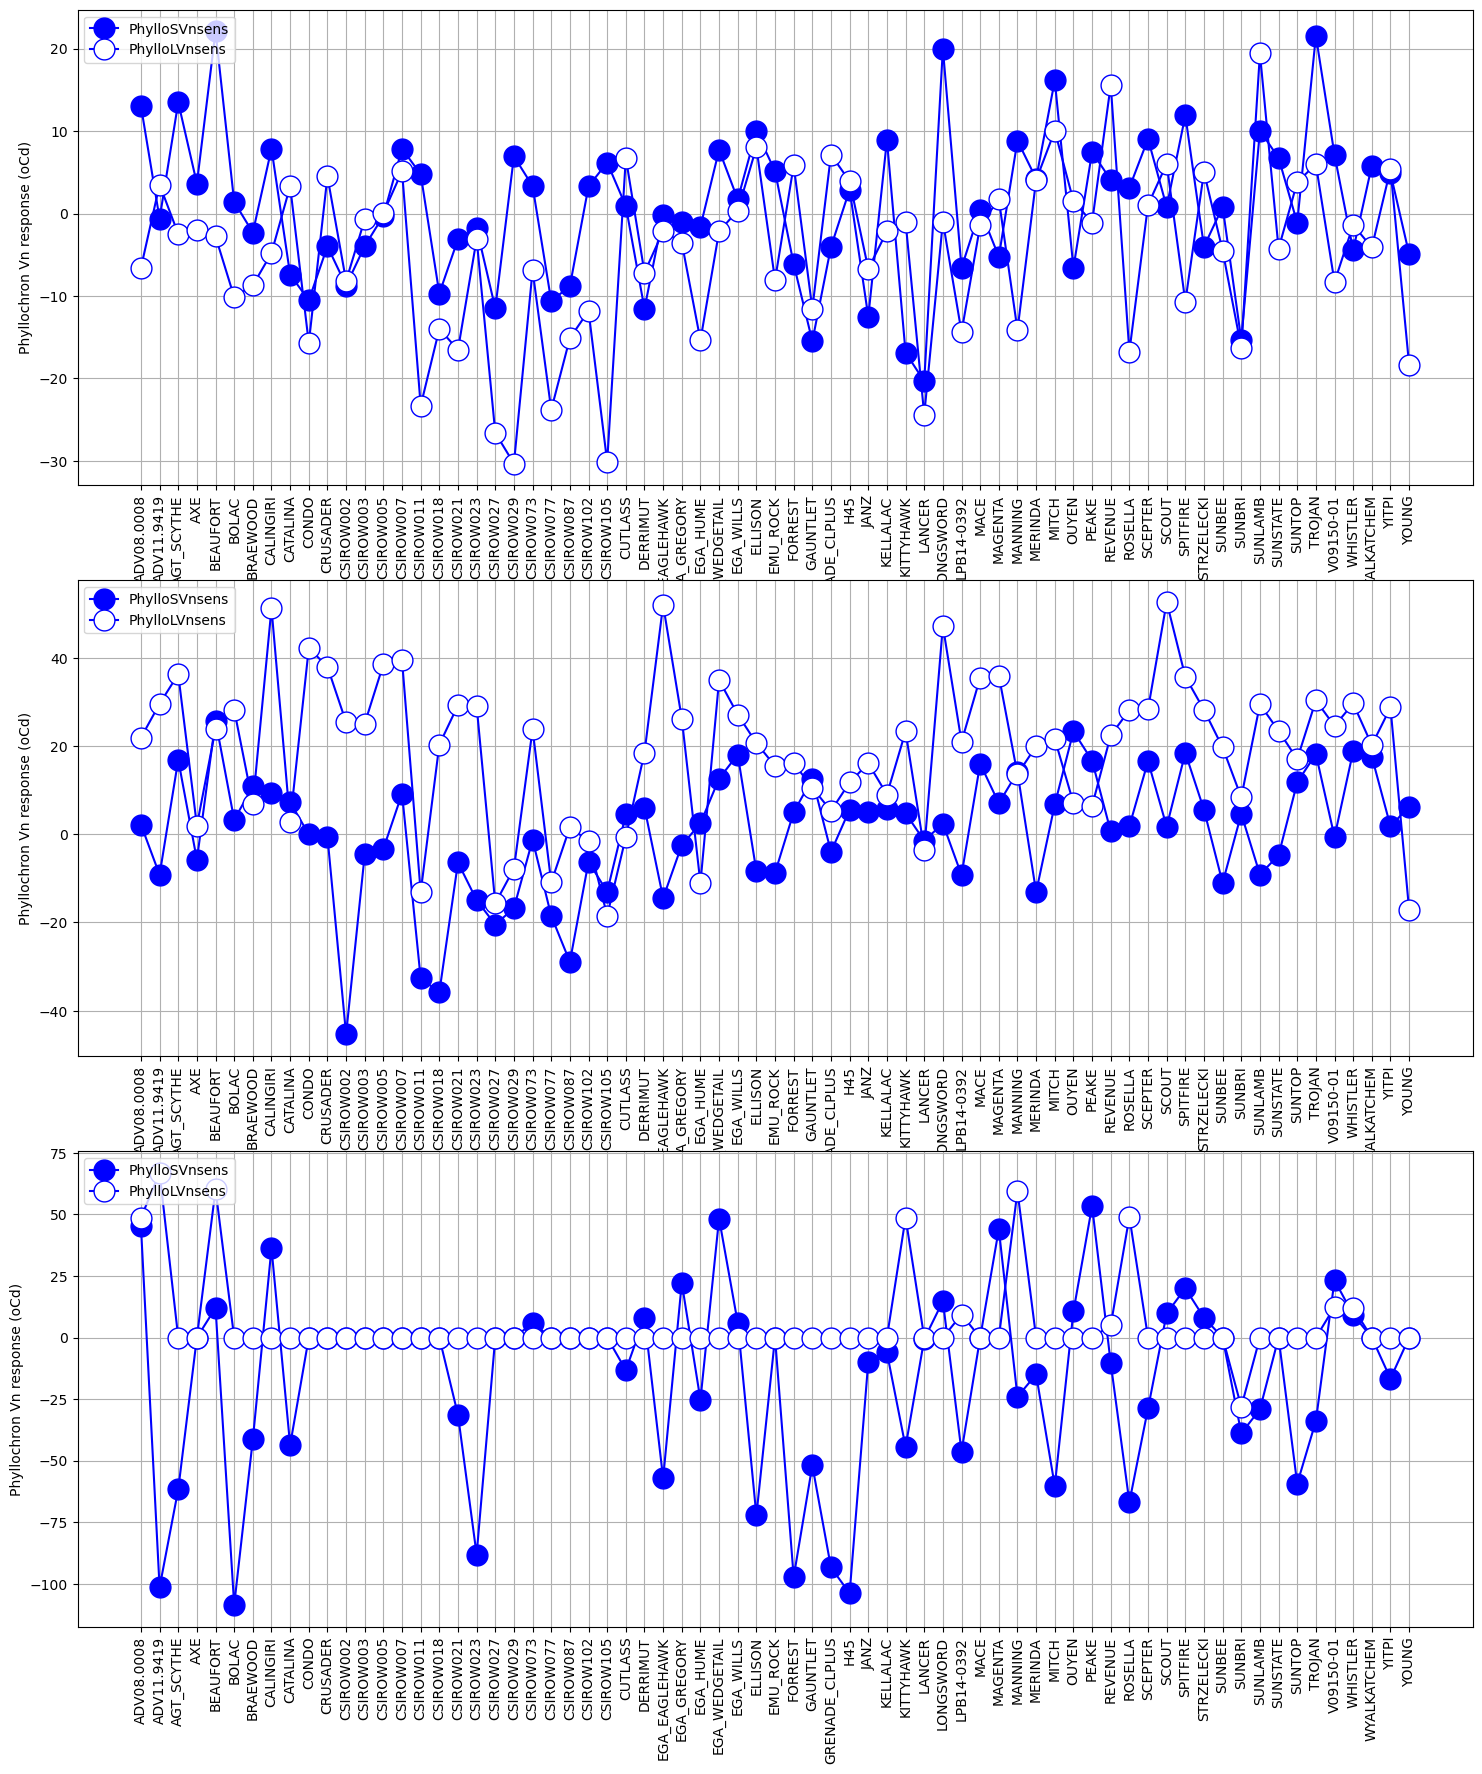

In [44]:
Graph = plt.figure(figsize=(18,21))
pos=1
for phase in ['1','2','3']:
    ax = Graph.add_subplot(3,1,pos)
    colpos = 1
    for Resp in ['PhylloSVnsens','PhylloLVnsens']:
        plt.plot(GenoParams.loc[:,Resp+phase],'-o',color = colors[colpos],mec=colors[colpos],mfc=fills[colpos],label=Resp,ms=15)
        colpos +=2
    plt.ylabel('Phyllochron Vn response (oCd)')
    plt.grid()
    for tick in ax.get_xticklabels():
                tick.set_rotation(90)
    plt.legend(loc=2)
    pos+=1
Graph.patch.set_facecolor('white')

### Under short day conditions most cultivars show no or very little vernalisation response
### Under LD conditions some cultivars show a vernalisation response but others dont

In [45]:
## Fill phyllochron and photoperiod parameters for the 3rd stage where they are missing
for c in Cults:
    #first try to use the non-vernalised phyllochron (default is to use the vernalised treatment)
    if np.isnan(GenoParams.loc[c,'Phyllochron-3']):
        GenoParams.loc[c,'Phyllochron3'] = FittedPhyllochron.loc[('WL',c),'Phyllochron-3']
    #if that doesn't work, use phyllochron from phase 2 adjusted
    if np.isnan(GenoParams.loc[c,'Phyllochron-3']):
        GenoParams.loc[c,'Phyllochron-3'] = GenoParams.loc[c,'Phyllochron-2'] * 1.4
    if np.isnan(GenoParams.loc[c,'PhylloPPSens3']):
        GenoParams.loc[c,'PhylloPPSens3'] = GenoParams.loc[c,'PhylloPPSens2'] 

In [46]:
def FLNplots(x,y):
    colorpos=0
    for p in ['L','S']:
        for v in ['N','V'] :
            plt.plot(FLN.loc[(p,v),x],FLN.loc[(p,v),y],'o',mec=colors[colorpos],mfc=fills[colorpos],label=p+v)
            colorpos +=1
    plt.ylabel(y)
    plt.xlabel(x)
    plt.legend()

## Determine cultivar response to PTQ

In [47]:
PTQindex = pd.MultiIndex.from_product([Envs,['1','2','3']],names=['Environment','PhylloPhase'])
PTQs = pd.DataFrame(index = PTQindex, data = [17,17,17,17,17,17,8,8,8,8,8,8], columns = ['Pp'])
PTQs.loc[:,'Temp'] = [22,22,22,5.8,22,22,22,22,22,5.8,22,22]
PTQs.loc[:,'LightIntensity'] =[300,300,300,160,300,300,300,300,300,160,300,300]
PTQs.loc[:,'Radn'] = [(PTQs.loc[x,'LightIntensity']*3600*PTQs.loc[x,'Pp'])/1e6 for x in PTQs.index]
PTQs.loc[:,'PTQ'] = PTQs.loc[:,'Radn']/PTQs.loc[:,'Temp']
PTQs.loc[:,'mec'] = ['r','r','r','purple','b','b','r','r','r','purple','b','b']
PTQs.loc[:,'mfc'] = ['r','r','r','purple','b','b','w','w','w','w','w','w']
PTQs.loc[:,'mark'] = ['o','s','^','o','s','^','o','s','^','o','s','^']
PTQs

Pp  Temp  LightIntensity    Radn       PTQ     mec  \
Environment PhylloPhase                                                       
WL          1            17  22.0             300  18.360  0.834545       r   
            2            17  22.0             300  18.360  0.834545       r   
            3            17  22.0             300  18.360  0.834545       r   
CL          1            17   5.8             160   9.792  1.688276  purple   
            2            17  22.0             300  18.360  0.834545       b   
            3            17  22.0             300  18.360  0.834545       b   
WS          1             8  22.0             300   8.640  0.392727       r   
            2             8  22.0             300   8.640  0.392727       r   
            3             8  22.0             300   8.640  0.392727       r   
CS          1             8   5.8             160   4.608  0.794483  purple   
            2             8  22.0             300   8.640  0.392727       b   
            3             8  22.0             300   8.640  0.392727       b   

                            mfc mark  
Environment PhylloPhase               
WL          1                 r    o  
            2                 r    s  
            3                 r    ^  
CL          1            purple    o  
            2                 b    s  
            3                 b    ^  
WS          1                 w    o  
            2                 w    s  
            3                 w    ^  
CS          1                 w    o  
            2                 w    s  
            3                 w    ^

In [48]:
1/0.005

200.0

In [49]:
FitSet = [('WS','1'),('WL','1'),('CS','2'),('CL','2')]
def fitLARparams(MinLAR):
    combs = pd.MultiIndex.from_product([[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4],[0.015]],names=['PTQhf','MaxLAR'])
    ModelValues = pd.DataFrame(index=combs, columns = PTQs.index)
    for comb in ModelValues.index:
        ModelValues.loc[comb,:] = [camp.LARPTQ(x,comb[1],minLAR=MinLAR,PTQhf=comb[0]) for x in PTQs.loc[:,'PTQ']]

    ObsLAR = pd.DataFrame(index=Cults,columns=PTQs.index)
    for cul in Cults:
        colpos = 0
        for ep in ObsLAR.columns:
            y = 1/FittedPhyllochron.loc[(ep[0],cul),'Phyllochron-'+ep[1]]
            ObsLAR.loc[cul,ep] = y
        for comb in ModelValues.index:
            obs = ObsLAR.loc[cul,FitSet].values
            pre = ModelValues.loc[comb,FitSet].values
            ModelValues.loc[comb,cul] = MUte.MathUtilities.CalcRegressionStats('WL',pre,obs).RMSE
    CultBestFitParams = pd.DataFrame(index=Cults,columns = ['PTQhf','MaxLAR'])
    for cul in Cults:
        CultBestFitParams.loc[cul,:] = ModelValues.loc[:,cul].idxmin()
    return CultBestFitParams

In [50]:
CampParams = pd.read_pickle('C:\\GitHubRepos\\npi\\Simulation\\ModelFitting\\CAMP_params.pkl')
CampParams.index = [x.capitalize() for x in CampParams.index]
CampParams = CampParams.loc[~CampParams.index.duplicated(),:].copy()

In [51]:
NameMap = pd.read_excel('C:/GitHubRepos/npi/Analysis/Controlled Environment/WheatNameMapping.xlsx','NameMap',index_col=1)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/GitHubRepos/npi/Analysis/Controlled Environment/WheatNameMapping.xlsx'

In [ ]:
CampParams.columns

In [ ]:
# Graph = plt.figure(figsize=(18,40))
# pos=1
# PTQ = np.divide(range(10),5)
# MinLAR=0.005
# CultBestFitParams = fitLARparams(MinLAR)
# for cul in Cults:
#     ax = Graph.add_subplot(13,6,pos)
#     # Plot best fits curves
#     LAR = []
#     LARbase = []
#     for ptq in PTQ:
#         LAR.append(camp.LARPTQ(ptq,CultBestFitParams.loc[cul,'MaxLAR'],minLAR=MinLAR,PTQhf=CultBestFitParams.loc[cul,'PTQhf']))
#         LARbase.append(camp.LARPTQ(ptq,CultBestFitParams.loc[cul,'MaxLAR']*.7,minLAR=MinLAR,PTQhf=CultBestFitParams.loc[cul,'PTQhf']*.5))
    
#     plt.plot(PTQ,LAR,'-',color='k')
#     if CampParams.loc[NameMap.loc[cul,'StandardName'].capitalize(),'VSBP_LN'] > 3.0:
#         plt.plot(PTQ,LARbase,'--',color='k')
   
#     #Plot Observed Data
#     for ep in PTQs.index:
#         if ep[1] != '3':
#             y = [1/FittedPhyllochron.loc[(ep[0],cul),'Phyllochron-'+ep[1]]]
#             x = PTQs.loc[ep,'PTQ']
#             plt.plot(x,y,marker=PTQs.loc[ep,'mark'],mec=PTQs.loc[ep,'mec'],mfc=PTQs.loc[ep,'mfc'],ms=9,mew=2)
#             plt.text(0.95,0.9,cul,horizontalalignment='right',transform = ax.transAxes,fontsize=14)
#             if ep not in FitSet:
#                 plt.plot(x,y,'x',ms=11,mew=1,color='k',mfc="none")
#         colpos+=1
#     pos+=1
# Graph.patch.set_facecolor('white')

In [ ]:
VrnRespPhylo = FittedPhyllochron.loc['WL','Phyllochron-2'] /  FittedPhyllochron.loc['CL','Phyllochron-2']
VrnRespPhylo = pd.DataFrame(VrnRespPhylo)
VrnRespPhylo.loc[:,'SPp'] = FittedPhyllochron.loc['WS','Phyllochron-2'] /  FittedPhyllochron.loc['CS','Phyllochron-2']
VrnRespPhylo.index = [NameMap.loc[x,'StandardName'].capitalize() for x in VrnRespPhylo.index]
VrnRespPhylo.loc[:,'VIHS_WS'] = [CampParams.loc[x,'VIBP_WS'] for x in VrnRespPhylo.index]
VrnRespPhylo.loc[:,'VIHS_CS'] = [CampParams.loc[x,'VIBP_CS'] for x in VrnRespPhylo.index]
VrnRespPhylo.loc[:,'VIHS_WL'] = [CampParams.loc[x,'VIBP_WL'] for x in VrnRespPhylo.index]
VrnRespPhylo.loc[:,'VIHS_CL'] = [CampParams.loc[x,'VIBP_CL'] for x in VrnRespPhylo.index]
VrnRespPhylo.loc[:,'WLD1/2'] = (FittedPhyllochron.loc['WL','Phyllochron-1'] /  FittedPhyllochron.loc['WL','Phyllochron-2']).values
VrnRespPhylo.loc[:,'CLD1/2'] = (FittedPhyllochron.loc['CL','Phyllochron-1'] /  FittedPhyllochron.loc['CL','Phyllochron-2']).values
VrnRespPhylo.loc[:,'WSD1/2'] = (FittedPhyllochron.loc['WS','Phyllochron-1'] /  FittedPhyllochron.loc['WS','Phyllochron-2']).values
VrnRespPhylo.loc[:,'CSD1/2'] = (FittedPhyllochron.loc['CS','Phyllochron-1'] /  FittedPhyllochron.loc['CS','Phyllochron-2']).values
VrnRespPhylo.loc[:,'WLD3/2'] = (FittedPhyllochron.loc['WL','Phyllochron-3'] /  FittedPhyllochron.loc['WL','Phyllochron-2']).values
VrnRespPhylo.loc[:,'CLD3/2'] = (FittedPhyllochron.loc['CL','Phyllochron-3'] /  FittedPhyllochron.loc['CL','Phyllochron-2']).values
VrnRespPhylo.loc[:,'WSD3/2'] = (FittedPhyllochron.loc['WS','Phyllochron-3'] /  FittedPhyllochron.loc['WS','Phyllochron-2']).values
VrnRespPhylo.loc[:,'CSD3/2'] = (FittedPhyllochron.loc['CS','Phyllochron-3'] /  FittedPhyllochron.loc['CS','Phyllochron-2']).values
VrnRespPhylo.loc[:,'WLD2/3'] = (FittedPhyllochron.loc['WL','Phyllochron-2'] /  FittedPhyllochron.loc['WL','Phyllochron-3']).values
VrnRespPhylo.loc[:,'CLD2/3'] = (FittedPhyllochron.loc['CL','Phyllochron-2'] /  FittedPhyllochron.loc['CL','Phyllochron-3']).values
VrnRespPhylo.loc[:,'WSD2/3'] = (FittedPhyllochron.loc['WS','Phyllochron-2'] /  FittedPhyllochron.loc['WS','Phyllochron-3']).values
VrnRespPhylo.loc[:,'CSD2/3'] = (FittedPhyllochron.loc['CS','Phyllochron-2'] /  FittedPhyllochron.loc['CS','Phyllochron-3']).values

In [ ]:
graph = plt.figure(figsize=(12,5))
ax = graph.add_subplot(1,2,1)
plt.plot(VrnRespPhylo.loc[:,'VIHS_WL'],VrnRespPhylo.loc[:,'WLD1/2'],'o',mec='r',mfc='r',label='Non-Vern')
plt.plot(VrnRespPhylo.loc[:,'VIHS_CL'],VrnRespPhylo.loc[:,'CLD1/2'],'o',mec='b',mfc='b',label='Vernalised')
plt.ylabel('Phyllo-1 / Phyllo-2' )
plt.title('Phase-2 (HS 3-7) Phyllochron reduction')
plt.xlabel('Vern Saturation Haun Stage')
plt.legend()
plt.plot([0,13],[1,1],'--',color='k')
plt.plot([0,3,3,13],[1,1,0.77,0.77],color='k')
plt.plot([3,3],[0,2],'--',color='k')
plt.plot([7,7],[0,2],'--',color='k')
plt.ylim(0.4,1.6)
plt.text(3.,1.5,'<--- Phase-2 --->')

ax = graph.add_subplot(1,2,2)
plt.plot(VrnRespPhylo.loc[:,'VIHS_WL'],VrnRespPhylo.loc[:,'WLD2/3'],'o',mec='r',mfc='r',label='Non-Vern')
plt.plot(VrnRespPhylo.loc[:,'VIHS_CL'],VrnRespPhylo.loc[:,'CLD2/3'],'o',mec='b',mfc='b',label='Vernalised')
plt.ylabel('Phyllo-2 / Phyllo-3' )
plt.title('Phase-3 (HS > 7) Phyllochron reduction')
plt.xlabel('Vern Saturation Haun Stage')
plt.legend()
plt.plot([0,13],[1,1],'--',color='k')
plt.plot([0,3,3,7,7,13],[0.75,0.75,1,1,0.65,0.65],color='k')
plt.plot([3,3],[0,2],'--',color='k')
plt.plot([7,7],[0,2],'--',color='k')
plt.ylim(0.4,1.6)
plt.text(3.,1.5,'<--- Phase-2 --->')

In [ ]:
plt.plot(VrnRespPhylo.loc[:,'VIHS_WL'],VrnRespPhylo.loc[:,'Phyllochron-2'],'o',mec = 'purple',mfc='purple',label='Long Pp')
plt.plot(VrnRespPhylo.loc[:,'VIHS_WS'],VrnRespPhylo.loc[:,'SPp'],'o',mec = 'purple',mfc='white',label='Short Pp')
plt.ylabel('NonVern Phyllo / Vern Phyllo' )
plt.title('Phase-2 (HS 3-7) Phyllochron response')
plt.xlabel('Vern Saturation Haun Stage for Non Vrn treatment')
plt.legend()
plt.plot([0,13],[1,1],'--',color='k')
plt.plot([0,3,3,13],[1,1,1.3,1.3],color='k')
plt.plot([3,3],[0,2],'--',color='k')
plt.plot([7,7],[0,2],'--',color='k')
plt.ylim(0.7,1.9)
plt.text(3.,1.8,'<---- Phase-2 ---->')

## Lets try something different

In [ ]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def piecewise_linear(x, y0, k2):
    return np.piecewise(x, [x < 2.5], [lambda x:k2*.75/1*x + y0-k2*.75/1*2.5, lambda x:k2*x + y0-k2*2.5])

for cul in ['AXE']:
    ax = Graph.add_subplot(13,6,pos)
    pos+=1
    for Pp in ['L','S']:
        base = HSData.Value <= 7 
        x = HSData.loc[base,'Value'].loc[([Pp+'N',Pp+'V'],cul)].dropna()
        y = HSData.loc[([Pp+'N',Pp+'V'],cul),'ApexAccumTt'].reindex(x.index)
        p , e = optimize.curve_fit(piecewise_linear, x.values, y.values)
        xd = np.linspace(0, 15, 100)
        plt.plot(y, x, "o")
        plt.plot(piecewise_linear(xd, *p),xd)

In [ ]:
TreatIndex = pd.MultiIndex.from_product([['L','S'],Cults],names=['Environment','Cultivar'])
CoarseFittedPhyllochron = pd.DataFrame(index = TreatIndex,columns=['Phyllochron'])
Graph = plt.figure(figsize=(18,40))
pos=1

def piecewise_linear(x, y0, k2):
    return np.piecewise(x, [x < 2.5], [lambda x:k2*.75/1*x + y0-k2*.75/1*2.5, lambda x:k2*x + y0-k2*2.5])

for cul in Cults:
    ax = Graph.add_subplot(13,6,pos)
    plt.text(0.05,0.9,cul,transform=ax.transAxes)
    pos+=1
    for Pp in ['L','S']:
        base = HSData.Value <= 7 
        x = HSData.loc[base,'Value'].loc[([Pp+'N',Pp+'V'],cul)].dropna()
        y = HSData.loc[([Pp+'N',Pp+'V'],cul),'ApexAccumTt'].reindex(x.index)
        plt.plot(y,x,'o',mec=styles.loc[Pp,'Edge'],mfc=styles.loc[Pp,'Fill'])
        p , e = optimize.curve_fit(piecewise_linear, x.values, y.values)
        CoarseFittedPhyllochron.loc[(Pp,cul),'LAR'] = 1/p[1]
        CoarseFittedPhyllochron.loc[(Pp,cul),'Phyllochron'] = p[1]
        xs = np.linspace(0, 7, 100)
        fitYs = piecewise_linear(xs, *p)
        plt.plot(fitYs,xs,styles.loc[Pp,'Lines'],color = 'k')
    plt.text(0.05,0.8,'Phyllo = '+ str( CoarseFittedPhyllochron.loc[('L',cul),'Phyllochron'])[:5],transform=ax.transAxes)
    plt.text(0.05,0.7, 'PpSens = '+ str(CoarseFittedPhyllochron.loc[('S',cul),'Phyllochron']/CoarseFittedPhyllochron.loc[('L',cul),'Phyllochron']-1)[:4],transform=ax.transAxes)
    plt.ylim(0,8)
    plt.xlim(0,1000)
Graph.patch.set_facecolor('white')

In [ ]:
NameMap.loc[:,'StandardName']

In [ ]:
ApsimParams = pd.DataFrame(CoarseFittedPhyllochron.loc['L','Phyllochron'])
ApsimParams.loc[:,'Phyllochron'] = [np.round(ApsimParams.loc[x,'Phyllochron']) for x in ApsimParams.index]
ApsimParams.columns = ['[Phenology].Phyllochron.BasePhyllochron.FixedValue']
ApsimParams.loc[:,'[Phenology].PhyllochronPpSensitivity.FixedValue'] = CoarseFittedPhyllochron.loc['S','Phyllochron']/CoarseFittedPhyllochron.loc['L','Phyllochron']-1
ApsimParams.loc[:,'[Phenology].PhyllochronPpSensitivity.FixedValue'] = [np.round(ApsimParams.loc[x,'[Phenology].PhyllochronPpSensitivity.FixedValue'],decimals=2) for x in ApsimParams.index]
ApsimParams.index = [NameMap.loc[x,'StandardName'] for x in ApsimParams.index]
ApsimParams.index.name = 'Cultivar'
ApsimParams.to_excel('CEReleaseParams_Aus.xlsx')

In [ ]:
plt.plot(ApsimParams.loc[:,'[Phenology].Phyllochron.BasePhyllochron.FixedValue'].values,ApsimParams.loc[:,'[Phenology].PhyllochronPpSensitivity.FixedValue'].values,'o')

In [ ]:
Graph = plt.figure(figsize=(18,400))
pos=1
for C in Cults:
    ax = Graph.add_subplot(13*3,2,pos)
    pos+=1
    c = NameMap.loc[C,'StandardName'].capitalize()
    Test = HSData.loc[(slice(None),C),:]
    for e in Envs: 
        UnVern = Test.Value <= CampParams.loc[c,'VIBP_'+e]
        Vern = Test.Value > CampParams.loc[c,'VIBP_'+e]
        plt.plot(Test.loc[UnVern,:].loc[e,'ApexAccumTt'].groupby('Date').mean(),
                 Test.loc[UnVern,:].loc[e,'Value'].groupby('Date').mean(),'o',
                 mec = styles.loc[e,'Edge'],mfc=styles.loc[e,'Fill'], ms=5)
        plt.plot(Test.loc[Vern,:].loc[e,'ApexAccumTt'].groupby('Date').mean(),
                 Test.loc[Vern,:].loc[e,'Value'].groupby('Date').mean(),'s',
                 mec = styles.loc[e,'Edge'],mfc=styles.loc[e,'Fill'], ms = 10)
        plt.text(0,12,c)
    BP = CoarseFittedPhyllochron.loc[('L',C),'Phyllochron']
    PpSens = CoarseFittedPhyllochron.loc[('S',C),'Phyllochron']/CoarseFittedPhyllochron.loc[('L',C),'Phyllochron']
    Emerg = FittedPhyllochron.loc[(slice(None),C),'EmergSoilTt'].mean()
    yHS = [0,7,11]
    xLD = [Emerg,
           Emerg + 7*BP,
           Emerg + 7*BP + 4*BP*1.4]
    xSD = [Emerg,
           Emerg + 7*BP * PpSens,
           Emerg + 7*BP*PpSens + 4*BP*1.4*PpSens]
    plt.plot(xLD,yHS,'-',color='k',lw=3)
    plt.plot(xSD,yHS,'--',color='k',lw=3)

In [ ]:
CoarseFittedPhyllochron

In [ ]:
Graph = plt.figure(figsize=(18,400))
pos=1
for C in Cults:
    
    ax = Graph.add_subplot(13*3,2,pos)
    pos+=1
    c = NameMap.loc[C,'StandardName'].capitalize()
    Test = HSData.loc[(slice(None),C),:]
    for e in Envs: 
        UnVern = Test.Value <= CampParams.loc[c,'VIBP_'+e]
        Vern = Test.Value > CampParams.loc[c,'VIBP_'+e]
        plt.plot(Test.loc[UnVern,:].loc[e,'ApexAccumTt'].groupby('Date').mean(),
                 Test.loc[UnVern,:].loc[e,'Value'].groupby('Date').mean(),'o',
                 mec = styles.loc[e,'Edge'],mfc=styles.loc[e,'Fill'], ms=5)
        plt.plot(Test.loc[Vern,:].loc[e,'ApexAccumTt'].groupby('Date').mean(),
                 Test.loc[Vern,:].loc[e,'Value'].groupby('Date').mean(),'s',
                 mec = styles.loc[e,'Edge'],mfc=styles.loc[e,'Fill'], ms = 10)
        plt.text(0,12,c)
        Emerg = FittedPhyllochron.loc[(e,C),'EmergSoilTt']
        yHS = [0,3,7,11]
        xTt = [Emerg]
        xTt.append(xTt[-1] + FittedPhyllochron.loc[(e,C),'Phyllochron-1'] * 3)
        xTt.append(xTt[-1] + FittedPhyllochron.loc[(e,C),'Phyllochron-2'] * 4)
        xTt.append(xTt[-1] + FittedPhyllochron.loc[(e,C),'Phyllochron-3'] * 4)
        plt.plot(xTt,yHS,ls = styles.loc[e,'Lines'],color=styles.loc[e,'Edge'],lw=3)

In [ ]:
CampParams.loc['Axe',:]

In [ ]:
HSData.loc[(slice(None),'AXE'),:].columns

## Make json string for experiment factors for APSIM

In [ ]:
Factors = pd.DataFrame(index = ['CL','WL','CS','WS'],
                      columns = ['SowDate', 'StartDate','EndDate','WeatherFile'],
                      data = [['2-Nov','2018-11-02','2019-03-04','CL.met'],
                              ['2-Nov','2018-11-02','2019-03-04','WL.met'],
                              ['4-Aug','2018-08-04','2019-03-18','CS.met'],
                              ['6-Jul','2018-07-06','2019-03-18','WS.met']])

In [ ]:
Factors

In [ ]:
BaseFactor = json.loads('{"$type": "Models.Factorial.CompositeFactor, Models",' +
                              '"Specifications": ['+
                               ' "[Weather]",'+
                                '"[SowingRule].Script.SowDate=",'+
                               '"[SowingRule].Script.EmergenceDate=",'+
                               '"[SowingRule].Script.CultivarName=",'+
                               '"[Clock].StartDate=",'+
                               ' "[Clock].EndDate="'+
                              '],'+
                              '"Paths": null,'+
                             ' "Values": null,'+
                              '"Name": "",'+
                              '"Children": ['+
                              '  {'+
                                 ' "$type": "Models.Weather, Models",'+
                                  '"FileName": "",'+
                                 ' "ExcelWorkSheetName": "",'+
                                 ' "Name": "",'+
                                  '"Children": [],'+
                                  '"IncludeInDocumentation": true,'+
                                 ' "Enabled": true,'+
                                 ' "ReadOnly": false'+
                               ' }'+
                              '],'+
                              '"IncludeInDocumentation": true,'+
                              '"Enabled": true,'+
                              '"ReadOnly": false'+
                            '}')
Children = []
for t in FittedPhyllochron.index:
    f = copy.deepcopy(BaseFactor)
    f['Name'] = t[0] + 'Cv' + NameMap.loc[t[1],'StandardName']
    f['Specifications'][1]+=Factors.loc[t[0],'SowDate']
    f['Specifications'][2]+=FittedPhyllochron.loc[t,'EmergenceDate'].strftime('%d-%b')
    f['Specifications'][3]+=NameMap.loc[t[1],'StandardName']
    f['Specifications'][4]+=Factors.loc[t[0],'StartDate']
    f['Specifications'][5]+=Factors.loc[t[0],'EndDate']
    f['Children'][0]['FileName'] = Factors.loc[t[0],'WeatherFile']
    f['Children'][0]['Name'] = t[0]
    Children.append(f)
    
with open('C:/GitHubRepos/npi/Analysis/Controlled Environment/LaTrobeFactors.json','w') as FactorsJSON:
    json.dump(Children,FactorsJSON,indent=2)

In [ ]:
EmergenceDateFrame = FittedPhyllochron.EmergenceDate.unstack()
EmergenceDateFrame.columns = [NameMap.loc[x,'StandardName'] for x in EmergenceDateFrame.columns]
EmergenceDateFrame.to_csv('C:\GitHubRepos\ApsimX\Tests\Validation\Wheat\LaTrobeEmergenceDates.csv')

In [ ]:
# EmergenceDateFrame = pd.DataFrame(FittedPhyllochron.EmergenceDate)
# EmergenceDateFrame.iloc[:,0] = [EmergenceDateFrame.loc[x,'EmergenceDate'].strftime('\'%d-%b\'') for x in FittedPhyllochron.index]
# EmergenceDateFrame = EmergenceDateFrame.unstack()
# EmergenceDateFrame.columns = EmergenceDateFrame.columns.droplevel(0)
# EmergenceDateFrame.columns = [NameMap.loc[x,'StandardName'] for x in EmergenceDateFrame.columns]
# EmergenceDateFrame.to_csv('C:\GitHubRepos\ApsimX\Tests\Validation\Wheat\LaTrobeEmergenceDates.csv')

## Make parameter file for PTQ phyllochron parameters

In [ ]:
ParamNameMap = {
    'MaxLAR':'[Phenology].MaxLAR.FixedValue',
    'PTQhf':'[Phenology].PTQhf.FixedValue',
}    
GenoParams.loc[:,'MaxLAR'] = [CultBestFitParams.loc[x,'MaxLAR'] for x in GenoParams.index]
GenoParams.loc[:,'PTQhf'] = [CultBestFitParams.loc[x,'PTQhf'] for x in GenoParams.index]
ParmasToExport = ['MaxLAR','PTQhf']
ToAPSIMGenoParams = GenoParams.reindex(ParmasToExport,axis=1)
ToAPSIMGenoParams.columns = [ParamNameMap[x] for x in ParmasToExport]
ToAPSIMGenoParams.index = [NameMap.loc[x,'StandardName'] for x in ToAPSIMGenoParams.index]
ToAPSIMGenoParams.index.name='Cultivar'
ToAPSIMGenoParams.to_excel('CEParamPTQ_Aus.xlsx',sheet_name = 'FittedParams')

## Make parameter file with base phyllochron and FLN parameters

In [ ]:
ParamNameMap = {
        'Phyllochron-2': '[Structure].Phyllochron.BasePhyllochron.FixedValue'
}    
ParmasToExport = ['Phyllochron-2']
ToAPSIMGenoParams = GenoParams.reindex(ParmasToExport,axis=1)
ToAPSIMGenoParams.columns = [ParamNameMap[x] for x in ParmasToExport]
ToAPSIMGenoParams.index = [NameMap.loc[x,'StandardName'] for x in ToAPSIMGenoParams.index]
ToAPSIMGenoParams.index.name='Cultivar'
ExistingModelFLNParams = pd.read_excel('CEParamsExistingModelFLN_Aus.xlsx',sheet_name='ObservedParams')
ExistingModelFLNParams.set_index('Cultivar',inplace=True)
ToAPSIMGenoParams = ToAPSIMGenoParams.join(ExistingModelFLNParams)
ToAPSIMGenoParams.round(decimals=1).to_excel('CEParamBasePhyllochron_Aus.xlsx',sheet_name = 'FittedParams')

In [ ]:
plt.plot(GenoParams.loc[:,'PTQhf'],GenoParams.loc[:,'Phyllochron-2'],'o')

In [ ]:
y=pd.to_numeric(GenoParams.loc[:,'PTQhf'].values)
x=pd.to_numeric(GenoParams.loc[:,'Phyllochron-2'].values)
plt.plot(x,y,'o')
ModFit = sm.regression.linear_model.OLS(y,  # Y variable
                                            sm.add_constant(x), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
RegFit = ModFit.fit();  
b = RegFit.params[1]
a = RegFit.params[0]
r2 = RegFit.rsquared
xs = [60,110]
ys = [a + b * x for x in xs]
plt.plot(xs,ys,'-')
plt.text(60,1.2,str(a)[:5]+" + " +str(b)[:5]+"*X\nr^2 = " + str(r2)[:4])

In [ ]:
RegFit.params

In [ ]:
ToAPSIMGenoParams

## Set up model to estimate leaf number

In [ ]:
Models = ['EstphyllochronBase','EstphyllochronBasePlusPP','EstphyllochronFittedPhases',
          'EstphyllochronFittedPhasesPlusPP','EstphyllochronFittedPhasesPlusFittedPp']

def EstphyllochronBase(HS,e,c):
    basephyllo = GenoParams.loc[c,'Phyllochron2'] 
    phyllo = basephyllo * 0.75
    if (HS>=3)&(HS < 7):
        phyllo = basephyllo * 1.0
    if (HS>= 7):
        phyllo = basephyllo * 1.4
    return phyllo

def EstphyllochronBasePlusPP(HS,e,c):
    phyllo = EstphyllochronBase(HS,e,c)
    if e[0] == 'S':
        phyllo *= GenoParams.loc[c,'PhylloPPSens2']
    return phyllo

def EstphyllochronFittedPhases(HS,e,c):
    phyllo = GenoParams.loc[c,'Phyllochron1'] 
    if (HS>=3)&(HS < 7):
        phyllo = GenoParams.loc[c,'Phyllochron2']
    if (HS>= 7):
        phyllo = GenoParams.loc[c,'Phyllochron3']
    return phyllo

def EstphyllochronFittedPhasesPlusPP(HS,e,c):
    phyllo = EstphyllochronFittedPhases(HS,e,c)
    if e[0] == 'S':
        phyllo *= GenoParams.loc[c,'PhylloPPSens2']
    return phyllo

def EstphyllochronFittedPhasesPlusFittedPp(HS,e,c):
    PpEffect1 = 1.0
    PpEffect2 = 1.0
    PpEffect3 = 1.0
    if e[0] == 'S':
        PpEffect1 = GenoParams.loc[c,'PhylloPPSens1']
        PpEffect2 = GenoParams.loc[c,'PhylloPPSens2']
        PpEffect3 = GenoParams.loc[c,'PhylloPPSens3']
    phyllo = GenoParams.loc[c,'Phyllochron1']*PpEffect1
    if (HS>=3)&(HS < 7):
        phyllo = GenoParams.loc[c,'Phyllochron2']*PpEffect2
    if (HS>= 7):
        phyllo = GenoParams.loc[c,'Phyllochron3']*PpEffect3
    return phyllo

def Estphyllochron(HS,e,c,model):
    if model == 'EstphyllochronBase':
        return EstphyllochronBase(HS,e,c)
    if model == 'EstphyllochronBasePlusPP':
        return EstphyllochronBasePlusPP(HS,e,c)
    if model == 'EstphyllochronFittedPhases':
        return EstphyllochronFittedPhases(HS,e,c)
    if model == 'EstphyllochronFittedPhasesPlusPP':
        return EstphyllochronFittedPhasesPlusPP(HS,e,c)
    if model == 'EstphyllochronFittedPhasesPlusFittedPp':
        return EstphyllochronFittedPhasesPlusFittedPp(HS,e,c)

DateIndex = pd.date_range(start='2018-07-06',end='2019-05-01')

def estLN(e,c,model):
    LN = pd.Series(index=DateIndex)
    CumTT = 0
    LNyesterday = 0
    SowDate = pd.to_datetime(SowDates[e])
    EndDate = SowDate + dt.timedelta(120)
    EDateIndex = pd.date_range(SowDate,EndDate)
    Emerged = False
    for d in EDateIndex:
        tt = Temp.loc[e,'AirTemp'].loc[d].mean()
        CumTT += tt
        if pd.to_datetime(d) >= FittedPhyllochron.loc[(e,c),'EmergenceDate']:
            phyllochron = Estphyllochron(LNyesterday,e,c,model)
            if Emerged == False:
                deltaHS = 0.5
                Emerged = True
            else:
                deltaHS = tt/phyllochron
            LNtoday = LNyesterday+deltaHS
            LN.loc[d] = LNtoday
            LNyesterday = LNtoday
        else:
            LN.loc[d] = 0 
    return LN 

In [ ]:
FittedPhyllochron.columns

In [ ]:
for  e in ['L','S']:
    LN = pd.Series(index=range(50))
    CumTT = 0
    LNyesterday = 0
    tt = 30
    for d in LN.index:
        if CumTT > 100:
                basePhyllo = 100
                phyllochron = Estphyllochron(LNyesterday,[e,0],'LONGSWORD',Models[1])
                deltaHS = tt/phyllochron
                LNtoday = LNyesterday+deltaHS
                LN.loc[d] = LNtoday
                LNyesterday = LNtoday
        else:
            LN.loc[d] = 0 
        CumTT += tt

    plt.plot(LN,label = e+' Pp')  
plt.legend()
plt.ylabel('Leaves')
plt.xlabel('Days')

In [ ]:
def CalcModelValuesAndFits(model):
    Dataindex = pd.MultiIndex.from_product([Envs,DateIndex],names=['Env','Date'])
    EstimatedLN = pd.DataFrame(index = Dataindex,columns = Cults)
    EstimatedLN.sort_index(inplace=True)
    for e in Envs:
        for c in Cults:
            EstimatedLN.loc[e,c] = estLN(e,c,model).values
    #Make time series graph of observed and predicted
    ObsVsPred = pd.DataFrame(index=pd.MultiIndex.from_product([[],[],[]],names=['Env','Cultivar','Date']),columns=['Obs','Pre'])
    ObsVsPred.sort_index(inplace=True)
    Graph = plt.figure(figsize=(18,40))
    pos=1
    for cul in Cults:
        ax = Graph.add_subplot(13,6,pos)
        pos+=1
        colpos = 0
        for env in Envs:
            y = HSData.loc[:,'Value'].loc[(env,cul)].dropna().values
            x = pd.to_datetime(HSData.loc[:,'Value'].loc[(env,cul)].dropna().index.get_level_values(1))
            plt.plot(x,y,'o',mec=colors[colpos],mfc=fills[colpos])
            plt.text(0.05,0.9,cul,transform=ax.transAxes)
            plt.plot(EstimatedLN.loc[env,cul],lines[colpos],color=colors[colpos])
            pair = pd.DataFrame(index = x,columns=['Obs','Pre'])
            pair.loc[:,'Obs'] = y
            pair.loc[:,'Pre'] = EstimatedLN.loc[env,cul].reindex(x)
            Pair = pd.concat([pair],keys=[(env,cul),'Date'],names=['Env','Cultivar'])
            ObsVsPred = pd.concat([ObsVsPred,Pair])
            colpos+=1
        plt.ylim(0,18)
        #plt.xlim(0,3000)
    #Make graph of residuals and calculates fits
    Graph = plt.figure(figsize=(18,40))
    Fits = pd.DataFrame(index = TreatIndex)
    Fits.sort_index(inplace=True)
    pos=1
    for cul in Cults:
        ax = Graph.add_subplot(13,6,pos)
        pos+=1
        colpos = 0
        for env in Envs:
            obs = ObsVsPred.loc[(env,cul),'Obs']
            pre = ObsVsPred.loc[(env,cul),'Pre']
            res = pre-obs
            plt.plot(obs,res,'o',mec=colors[colpos],mfc=fills[colpos],label=env)
            plt.plot([0,16],[0,0],color='k')
            plt.text(0.6,0.9,cul,transform=ax.transAxes)
            RegStats = MUte.MathUtilities.CalcRegressionStats('LN',pre,obs)
            Fits.loc[(env,cul),'NSE'] = RegStats.NSE
            Fits.loc[(env,cul),'RMSE'] = RegStats.RMSE
            Fits.loc[(env,cul),'ME'] = RegStats.ME
            try:
                HSFI = FLN.loc[(env[0],env[1],cul),'HSFI']
            except:
                print(env+" "+cul)
            plt.plot([HSFI]*2,[-2.7,2.7],'^--',mec=colors[colpos],mfc=fills[colpos],color=colors[colpos])
            colpos+=1
        if pos == 2:
             plt.legend()
        plt.ylim(-9,9)
    Graph = plt.figure(figsize=(18,21))
    
    #Make graphs of model fits
    pos=1
    for var in Fits.columns:
        ax = Graph.add_subplot(4,1,pos)
        colpos = 0
        for env in Envs:
            plt.plot(Fits.loc[env,var],'-o',color = colors[colpos],mec=colors[colpos],mfc=fills[colpos],label=env,ms=15)
            colpos +=1
        plt.ylabel(var)
        plt.grid()
        for tick in ax.get_xticklabels():
                    tick.set_rotation(90)
        plt.ylim(-1.5,6)
        plt.legend(loc=2)
        pos +=1
    
    return EstimatedLN, Fits

In [ ]:
Models

# Try differnt models for quantifying leaf appearance

## EstphyllochronBase

First lets test a basic phyllochron model with base phyllochron defined using the fitted leaf appearance data in phase 2 and the phyllochrons in phase 1 and 3 calculated as 0.75 and 1.4 times the base phyllochron

In [ ]:
EstphyllochronBase_Results = CalcModelValuesAndFits('EstphyllochronBase')

## EstphyllochronBasePlusPP

In [ ]:
EstphyllochronBasePlusPP_Results = CalcModelValuesAndFits('EstphyllochronBasePlusPP')

## EstphyllochronFittedPhases

In [ ]:
EstphyllochronFittedPhases_Results = CalcModelValuesAndFits('EstphyllochronFittedPhases')

In [ ]:
EstphyllochronFittedPhasesPlusPP_Results = CalcModelValuesAndFits('EstphyllochronFittedPhasesPlusPP')

In [ ]:
EstphyllochronFittedPhasesPlusFittedPp_Results = CalcModelValuesAndFits('EstphyllochronFittedPhasesPlusFittedPp')

In [ ]:
Cults

In [ ]:
Graph = plt.figure(figsize=(10,5))
pos=1
cul = 'ADV11.9419'
ax = Graph.add_subplot(1,1,1)
pos+=1
colpos = 0
for env in Envs:
    base = (HSData.Value >= 0) & (HSData.Value <= 37) 
    y = HSData.loc[base,'Value'].loc[(env,cul)].dropna().values
    x = pd.to_datetime(HSData.loc[base,'Value'].loc[(env,cul)].dropna().index.get_level_values(1))
    plt.plot(x,y,'o',mec=colors[colpos],mfc=fills[colpos])
    plt.plot(EstphyllochronFittedPhasesPlusFittedPp_Results[0].loc[env,cul],lines[colpos],color=colors[colpos])
    colpos+=1
plt.ylim(0,18)
    #plt.xlim(0,3000)

In [ ]:
Graph = plt.figure(figsize=(10,15))
pos=1
var  = 'NSE'
for m in Models:
    FitData = globals()[m+'_Results'][1]
    ax = Graph.add_subplot(5,1,pos)
    colpos = 0
    for env in Envs:
        plt.plot(FitData.loc[env,var],'-o',color = colors[colpos],mec=colors[colpos],mfc=fills[colpos],label=env,ms=5)
        colpos +=1
    plt.ylabel(var)
    plt.grid()
    for tick in ax.get_xticklabels():
                tick.set_rotation(90)
    plt.ylim(-1.5,1.1)
    plt.legend(loc=2)
    plt.text(0.05,0.05,m,transform=ax.transAxes)
    pos +=1

In [ ]:
Graph = plt.figure(figsize=(10,15))
pos=1
var  = 'RMSE'
for m in Models:
    FitData = globals()[m+'_Results'][1]
    ax = Graph.add_subplot(5,1,pos)
    colpos = 0
    for env in Envs:
        plt.plot(FitData.loc[env,var],'-o',color = colors[colpos],mec=colors[colpos],mfc=fills[colpos],label=env,ms=5)
        colpos +=1
    plt.ylabel(var)
    plt.grid()
    for tick in ax.get_xticklabels():
                tick.set_rotation(90)
    plt.ylim(0,6)
    plt.legend(loc=2)
    plt.text(0.05,0.05,m,transform=ax.transAxes)
    pos +=1

In [ ]:
Graph = plt.figure(figsize=(10,15))
pos=1
var  = 'ME'
for m in Models:
    FitData = globals()[m+'_Results'][1]
    ax = Graph.add_subplot(5,1,pos)
    colpos = 0
    for env in Envs:
        plt.plot(FitData.loc[env,var],'-o',color = colors[colpos],mec=colors[colpos],mfc=fills[colpos],label=env,ms=5)
        colpos +=1
    plt.ylabel(var)
    plt.grid()
    for tick in ax.get_xticklabels():
                tick.set_rotation(90)
    plt.ylim(-6,6)
    plt.legend(loc=2)
    plt.text(0.05,0.05,m,transform=ax.transAxes)
    pos +=1

In [ ]:
Graph = plt.figure(figsize=(18,30))
pos=1
for var in ['Phyllochron1','Phyllochron2','Phyllochron3','PhylloPPSens1','PhylloPPSens2','PhylloPPSens3']:
    ax = Graph.add_subplot(6,1,pos)
    colpos = 0
    plt.plot(GenoParams.loc[:,var],'-o',color = 'k',ms=15)
    plt.ylabel(var)
    plt.grid()
    for tick in ax.get_xticklabels():
                tick.set_rotation(90)
    pos+=1

In [ ]:
def corMatrix(Vars):
    pos=1
    c = len(Vars)
    for var in Vars:
        for var2 in Vars:
            ax = Graph.add_subplot(c,c,pos)
            y = GenoParams.loc[:,var]
            x = GenoParams.loc[:,var2]
            plt.plot(x,y,'o')
            plt.tick_params(axis='both',labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            if pos in range(1,c*c,c):
                plt.text(-.2,0.2,var,transform=ax.transAxes,horizontalalignment='right',fontsize=12)
                plt.tick_params(axis='y',labelbottom=False, labeltop=False, labelleft=True, labelright=False)
            if pos > (c * c - c ):
                plt.tick_params(axis='x',labelbottom=True, labeltop=False, labelleft=False, labelright=False)
                plt.text(0,-0.4,var2,transform=ax.transAxes,rotation=0,verticalalignment='bottom',fontsize=12)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            pos+=1

In [ ]:
Graph = plt.figure(figsize=(18,18))
corMatrix(['Phyllochron1','Phyllochron2','Phyllochron3','PhylloPPSens1','PhylloPPSens2','PhylloPPSens3'])

In [ ]:
Graph = plt.figure(figsize=(18,18))
corMatrix(['Phyllochron1','Phyllochron2','Phyllochron3','MinLeafNumber', 
        'FLNPPSens','FLNVnSens'])

In [ ]:
Graph = plt.figure(figsize=(18,18))
corMatrix(['PhylloPPSens1','PhylloPPSens2','PhylloPPSens3','MinLeafNumber', 
        'FLNPPSens','FLNVnSens'])

In [ ]:
Graph = plt.figure(figsize=(18,18))
pos=1
Vars = ['PhylloSVnsens1', 'PhylloLVnsens1', 'PhylloVPPsens1', 'PhylloNPPsens1',
       'Phyllochron1', 'PhylloSVnsens2', 'PhylloLVnsens2', 'PhylloVPPsens2',
       'PhylloNPPsens2', 'Phyllochron2', 'Phyllochron3', 'MinLeafNumber', 
        'FLNPPSens','FLNVnSens']
c = len(Vars)
for var in Vars:
    for var2 in Vars:
        ax = Graph.add_subplot(c,c,pos)
        x = GenoParams.loc[:,var]
        y = GenoParams.loc[:,var2]
        plt.plot(x,y,'o')
        
        if pos <= c:
            plt.text(0,1.2,var2,transform=ax.transAxes,rotation=80,verticalalignment='bottom',fontsize=12)
        if pos in range(1,c*c,c):
            plt.text(-.2,0.2,var,transform=ax.transAxes,horizontalalignment='right',fontsize=12)
        Axis.spines['right'].set_visible(False)
        Axis.spines['top'].set_visible(False)
        plt.tick_params(axis='both',labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        pos+=1

## the two below are confounded, ignore correlations


In [ ]:
x = GenoParams.loc[:,'PhylloPPSens1']
y = GenoParams.loc[:,'PhylloVPPsens1']
plt.plot(x,y,'o')

In [ ]:
x = GenoParams.loc[:,'PhylloPPSens2']
y = GenoParams.loc[:,'PhylloVPPsens2']
plt.plot(x,y,'o')

In [ ]:
CultivarMaxLAR = {'ADV08.0008': 0.018,
 'ADV11.9419': 0.018,
 'AGT_SCYTHE': 0.018,
 'AXE': 0.018,
 'BEAUFORT': 0.018,
 'BOLAC': 0.023,
 'BRAEWOOD': 0.015,
 'CALINGIRI': 0.023,
 'CATALINA': 0.023,
 'CONDO': 0.023,
 'CRUSADER': 0.023,
 'CSIROW002': 0.023,
 'CSIROW003': 0.023,
 'CSIROW005': 0.023,
 'CSIROW007': 0.023,
 'CSIROW011': 0.023,
 'CSIROW018': 0.023,
 'CSIROW021': 0.023,
 'CSIROW023': 0.023,
 'CSIROW027': 0.028,
 'CSIROW029': 0.023,
 'CSIROW073': 0.028,
 'CSIROW077': 0.028,
 'CSIROW087': 0.023,
 'CSIROW102': 0.023,
 'CSIROW105': 0.028,
 'CUTLASS': 0.023,
 'DERRIMUT': 0.023,
 'EGA_EAGLEHAWK': 0.018,
 'EGA_GREGORY': 0.028,
 'EGA_HUME': 0.028,
 'EGA_WEDGETAIL': 0.018,
 'EGA_WILLS': 0.023,
 'ELLISON': 0.018,
 'EMU_ROCK': 0.023,
 'FORREST': 0.018,
 'GAUNTLET': 0.028,
 'GRENADE_CLPLUS': 0.018,
 'H45': 0.028,
 'JANZ': 0.028,
 'KELLALAC': 0.028,
 'KITTYHAWK': 0.028,
 'LANCER': 0.028,
 'LONGSWORD': 0.028,
 'LPB14-0392': 0.023,
 'MACE': 0.023,
 'MAGENTA': 0.018,
 'MANNING': 0.018,
 'MERINDA': 0.023,
 'MITCH': 0.028,
 'OUYEN': 0.028,
 'PEAKE': 0.028,
 'REVENUE': 0.018,
 'ROSELLA': 0.023,
 'SCEPTER': 0.018,
 'SCOUT': 0.023,
 'SPITFIRE': 0.023,
 'STRZELECKI': 0.023,
 'SUNBEE': 0.023,
 'SUNBRI': 0.028,
 'SUNLAMB': 0.023,
 'SUNSTATE': 0.028,
 'SUNTOP': 0.023,
 'TROJAN': 0.018,
 'V09150-01': 0.023,
 'WHISTLER': 0.023,
 'WYALKATCHEM': 0.023,
 'YITPI': 0.018,
 'YOUNG': 0.028}